# PRE - PROCESSING

## Import functions

In [ ]:
#pip install meteostat

In [ ]:
import holidays # For working with holiday data
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Import the necessary module
from sklearn.ensemble import RandomForestRegressor

from datetime import datetime
from meteostat import Stations, Daily # For working with weather data
from xgboost import plot_importance


from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

import joblib

In [ ]:
## Features Functions

def create_datetime_features(df):
    """
    Creates time series features from datetime index
    Adapted from: https://www.kaggle.com/code/robikscube/tutorial-time-series-forecasting-with-xgboost#Look-at-Worst-and-Best-Predicted-Days
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week
    df['date'] = pd.to_datetime(df.index.date)
    return df

def get_holiday_features(df, country_code='US'):
    """
    Creates holiday features from datetime index
    """
    year_range = list(range(min(df.index.year), max(df.index.year) + 1))
    country_holidays = holidays.country_holidays(
        country_code,
        years=year_range,
        observed=False
    )
    holiday_df = pd.DataFrame(country_holidays.items())
    holiday_df.columns = ['date', 'holiday']
    holiday_df['date'] = pd.to_datetime(holiday_df['date'])
    return holiday_df

def get_weather_features(df, lat, lon):
    """
    Creates weather features based on latitude and longitude
    """
    room_temperature = 20  # Weather data is in Celsius
    start = min(df.index)
    end = max(df.index)

    stations = Stations()
    stations = stations.nearby(lat, lon)
    station = stations.fetch(1)

    # Get daily data
    weather_data = Daily(station['wmo'][0], start, end)
    weather_data = weather_data.fetch()
    weather_data = weather_data.dropna(axis=1)
    weather_data = weather_data.reset_index()
    weather_data['tmin_abs_diff_from_room_temperature'] = abs(weather_data['tmin'] - room_temperature)
    weather_data['tmax_abs_diff_from_room_temperature'] = abs(weather_data['tmax'] - room_temperature)
    weather_data = weather_data.rename(columns ={'time': 'date'})

    return weather_data

## Import data and feature engineering

In [ ]:
main = 'https://raw.githubusercontent.com/Brunchcode/Forecasting-Energy-Consumption-Using-Machine-Learning/main/data/Timeseries/Timeseries_PJM_DOM_consumption_2006_to_2024.csv'

data_main = pd.read_csv(main,index_col=[0], parse_dates=[0])
data = create_datetime_features(data_main)
holiday_features = get_holiday_features(data)
weather_features = get_weather_features(data, 37.5407, -77.4360) # Richmond Capital of Virgina
data['datetime'] = data.index
data = data.merge(holiday_features, how='left', on='date')
data['holiday'] = data['holiday'].fillna('')
data = pd.get_dummies(data)
data = data.merge(weather_features, how='left', on='date')


remove_for_case_study = datetime(2020, 1, 1)
data_till_2019 = data.loc[data['datetime'] <= remove_for_case_study].copy()
case_study_data = data.loc[data['datetime'] > remove_for_case_study].copy()

In [ ]:
data.head()

In [ ]:
data.tail()

In [ ]:
data_till_2019.head()

In [ ]:
data_till_2019.tail()

In [ ]:
case_study_data.head()

In [ ]:
case_study_data.tail()

# SPLITING AND SCALING

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from joblib import dump, load
from datetime import datetime

# Step 0: Set the global random seed
np.random.seed(22)

# Step 1: Data Preprocessing and Normalization using Min-Max Scaling
split_date = datetime(2016, 1, 1)
train = data_till_2019.loc[data_till_2019['datetime'] <= split_date].copy()
test = data_till_2019.loc[data_till_2019['datetime'] > split_date].copy()

train_drop_cols = ['date', 'datetime', 'energy_consumption_mw']
X_train = train.drop(columns=train_drop_cols)
y_train = train['energy_consumption_mw']
X_test = test.drop(columns=train_drop_cols)
y_test = test['energy_consumption_mw']

# Normalize the features using Min-Max Scaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# RESULTS

## Linear Regression

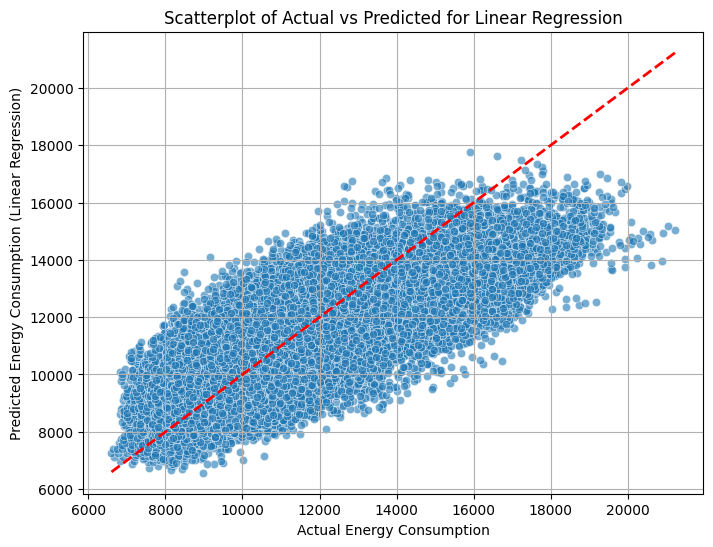

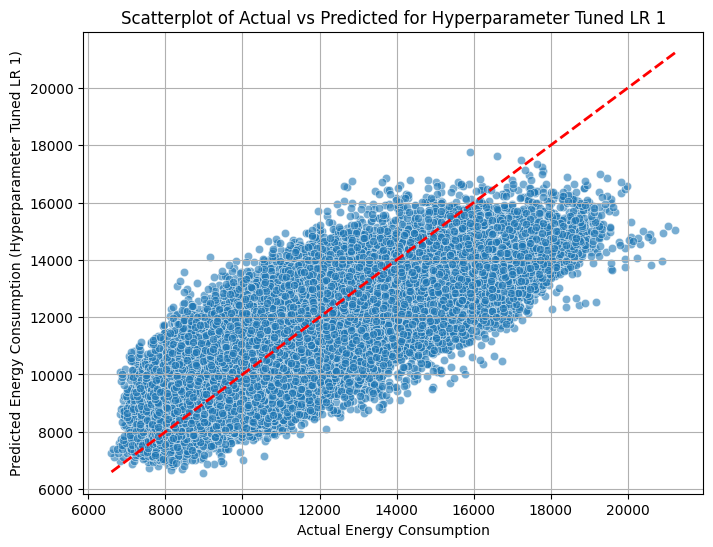

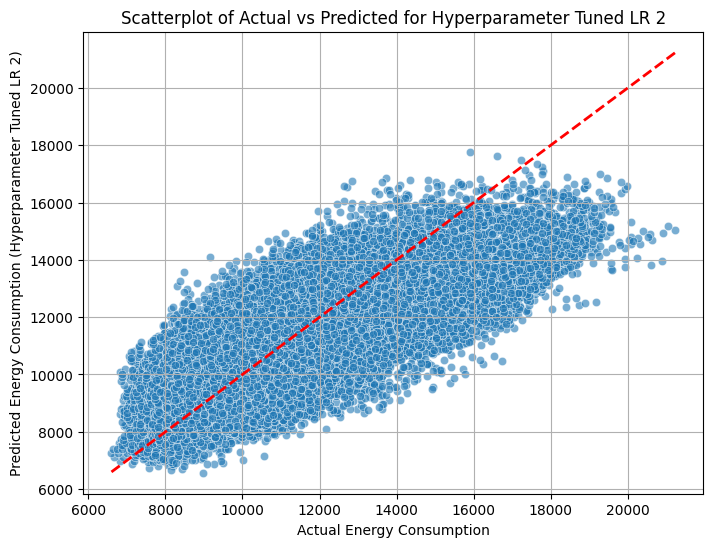

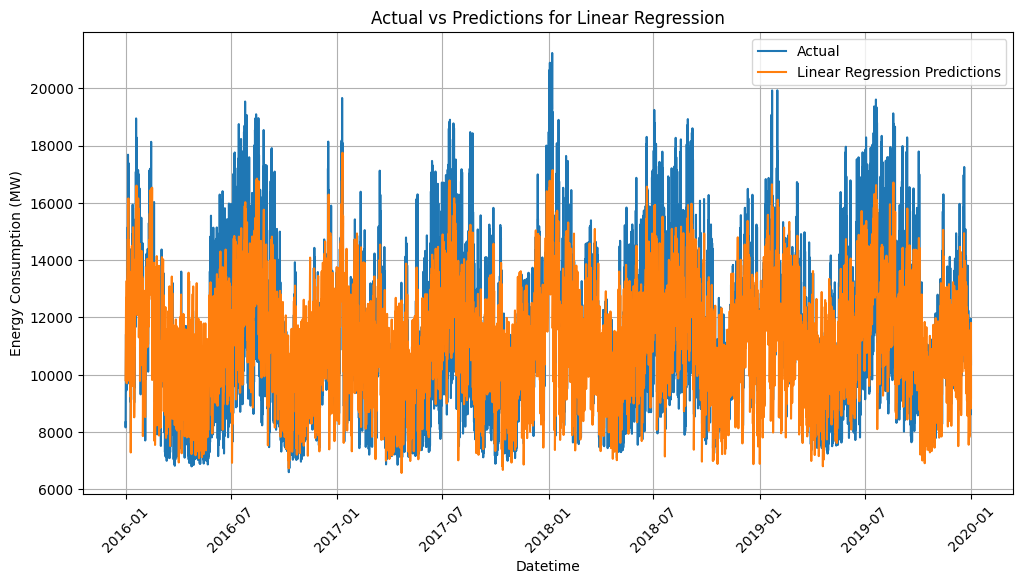

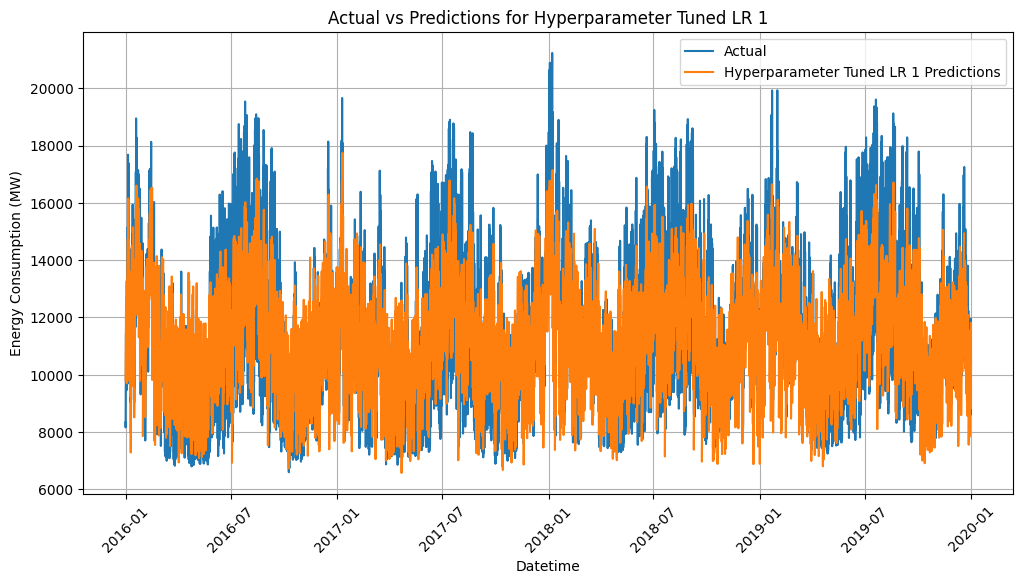

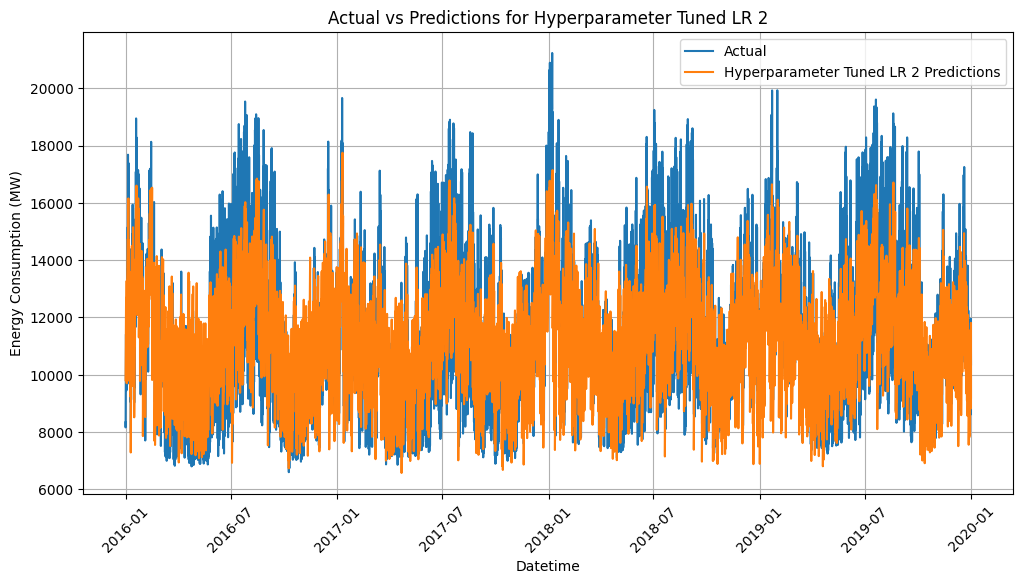

Feature Importance for Linear Regression:
holiday_                                        7.916226e+13
holiday_Martin Luther King Jr. Day              7.916226e+13
holiday_Washington's Birthday                   7.916226e+13
holiday_Independence Day                        7.916226e+13
holiday_Veterans Day                            7.916226e+13
holiday_New Year's Day                          7.916226e+13
holiday_Thanksgiving                            7.916226e+13
holiday_Christmas Day                           7.916226e+13
holiday_Labor Day                               7.916226e+13
holiday_Memorial Day                            7.916226e+13
holiday_Columbus Day                            7.916226e+13
dayofyear                                       7.666781e+04
tmin                                            1.175332e+04
tmin_abs_diff_from_room_temperature             9.940019e+03
tmax_abs_diff_from_room_temperature             6.622397e+03
hour                                       

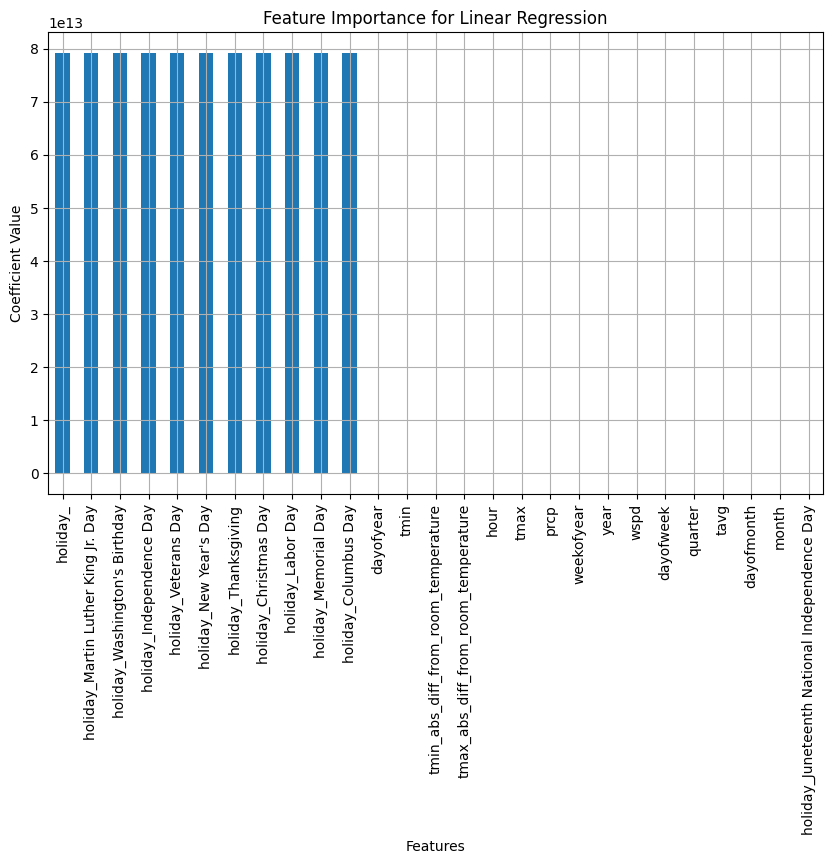

Feature Importance for Hyperparameter Tuned LR 1:
dayofyear                                       7.666908e+04
tmin                                            1.175336e+04
tmin_abs_diff_from_room_temperature             9.939997e+03
tmax_abs_diff_from_room_temperature             6.622395e+03
hour                                            3.004100e+03
tmax                                            2.412631e+03
prcp                                            6.723791e+02
weekofyear                                      3.463936e+02
year                                            3.415064e+02
holiday_Juneteenth National Independence Day   -7.457857e-11
wspd                                           -4.619883e+02
dayofweek                                      -7.614599e+02
quarter                                        -1.077561e+03
holiday_                                       -1.854700e+03
holiday_Martin Luther King Jr. Day             -1.871495e+03
holiday_Washington's Birthday      

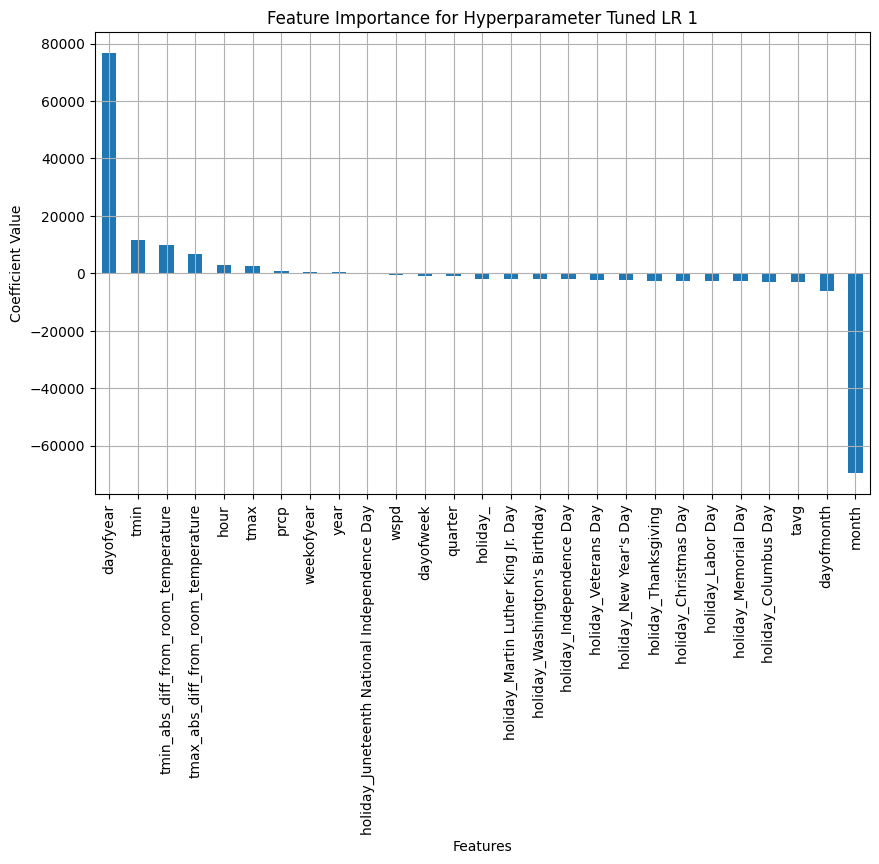

Feature Importance for Hyperparameter Tuned LR 2:
dayofyear                                       7.666908e+04
tmin                                            1.175336e+04
tmin_abs_diff_from_room_temperature             9.939997e+03
tmax_abs_diff_from_room_temperature             6.622395e+03
hour                                            3.004100e+03
tmax                                            2.412631e+03
prcp                                            6.723791e+02
holiday_                                        4.927667e+02
holiday_Martin Luther King Jr. Day              4.759718e+02
holiday_Washington's Birthday                   3.685334e+02
weekofyear                                      3.463936e+02
year                                            3.415064e+02
holiday_Independence Day                        3.258463e+02
holiday_Veterans Day                            4.714596e+01
1                                              -4.087347e-12
holiday_Juneteenth National Indepen

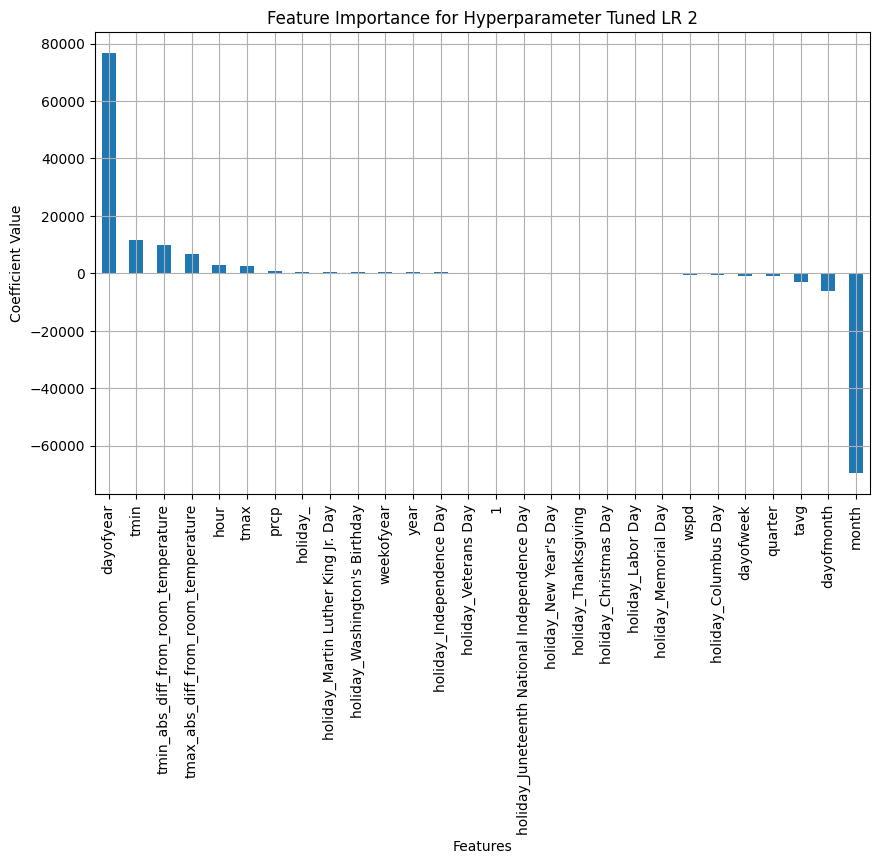

In [33]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from joblib import load
import matplotlib.pyplot as plt
import seaborn as sns

# Load the Linear Regression models
lr_all = load('saved models/LR/lr_all2019_reg_model.joblib')
lr_hp1 = load('saved models/LR/lr_best_model_grid_search.joblib')
lr_hp2 = load('saved models/LR/lr_best_model_grid_search2.joblib')

# List of Linear Regression models
lr_models = [
    ('Linear Regression', lr_all),
    ('Hyperparameter Tuned LR 1', lr_hp1),
    ('Hyperparameter Tuned LR 2', lr_hp2)
]

# Ensure y_test is numeric and handle invalid values
y_test_numeric = pd.to_numeric(y_test, errors='coerce')  # Convert to numeric, set invalid values to NaN
y_test_numeric = y_test_numeric.dropna()  # Drop any NaN values

# Initialize an empty list to store linear regression evaluations
lr_evaluations = []

# Create a DataFrame to store the actuals and predictions
results_df = test[['datetime', 'energy_consumption_mw']].copy()
results_df.columns = ['datetime', 'Actual']  # Rename for clarity

# Evaluate each linear regression model
for model_name, model in lr_models:
    predictions = model.predict(X_test_scaled)
    results_df[model_name + ' Predictions'] = predictions
    
    mae = mean_absolute_error(y_test_numeric, predictions)
    rmse = mean_squared_error(y_test_numeric, predictions, squared=False) 
    mape = mean_absolute_percentage_error(y_test_numeric, predictions) * 100
    r2 = r2_score(y_test_numeric, predictions)
    
    lr_evaluations.append([model_name, mape, mae, rmse, r2])

# Convert linear regression evaluations to a DataFrame and export as CSV
lr_evaluations_df = pd.DataFrame(lr_evaluations, columns=['Model Name', 'MAPE', 'MAE', 'RMSE', 'R2'])
lr_evaluations_df.to_csv('results/lr_model_evaluations.csv', index=False)

# Export the combined actual vs. predictions CSV for all models
results_df.set_index('datetime', inplace=True)
results_df.to_csv('results/actuals_vs_predictions_combined.csv')

# Plot scatter plot of True vs Predicted values for each linear regression model
for model_name, model in lr_models:
    predictions = model.predict(X_test_scaled)
    
    # Convert predictions to numeric and remove any non-finite values
    predictions_numeric = pd.to_numeric(predictions, errors='coerce')
    predictions_numeric = predictions_numeric[np.isfinite(predictions_numeric)]
    
    # Ensure both arrays are the same length
    min_len = min(len(y_test_numeric), len(predictions_numeric))
    y_test_numeric_trimmed = y_test_numeric.iloc[:min_len]  # Trim y_test to min length
    predictions_numeric_trimmed = predictions_numeric[:min_len]  # Trim predictions to min length
    
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_test_numeric_trimmed, y=predictions_numeric_trimmed, alpha=0.6)
    
    # Plot a perfect prediction line (y = x)
    plt.plot([y_test_numeric_trimmed.min(), y_test_numeric_trimmed.max()],
             [y_test_numeric_trimmed.min(), y_test_numeric_trimmed.max()],
             color='red', lw=2, linestyle='--')
    
    plt.xlabel('Actual Energy Consumption')
    plt.ylabel(f'Predicted Energy Consumption ({model_name})')
    plt.title(f'Scatterplot of Actual vs Predicted for {model_name}')
    plt.grid(True)
    plt.show()

# Line plot of predictions vs actuals for each model separately
for model_name, model in lr_models:
    predictions = model.predict(X_test_scaled)
    predictions_numeric = pd.to_numeric(predictions, errors='coerce')
    predictions_numeric = predictions_numeric[np.isfinite(predictions_numeric)]
    
    # Ensure both arrays are the same length
    min_len = min(len(test['datetime']), len(predictions_numeric))
    
    plt.figure(figsize=(12, 6))
    plt.plot(test['datetime'][:min_len], y_test_numeric.iloc[:min_len], label='Actual')
    plt.plot(test['datetime'][:min_len], predictions_numeric[:min_len], label=f'{model_name} Predictions')
    
    plt.xlabel('Datetime')
    plt.ylabel('Energy Consumption (MW)')
    plt.title(f'Actual vs Predictions for {model_name}')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.show()

# Feature importance (coefficients) and plotting for each linear regression model
for model_name, model in lr_models:
    # Check if the model is a pipeline
    if hasattr(model, 'steps'):
        # Access the linear regression model in the pipeline using 'linear' step
        linear_model = model.named_steps['linear']
        poly_features = model.named_steps['poly']  # Access PolynomialFeatures step
        
        # Get the feature names created by PolynomialFeatures
        feature_names = poly_features.get_feature_names_out(X_test.columns)
    else:
        linear_model = model
        feature_names = X_test.columns  # Use original feature names if no polynomial features

    # Extract feature importance (coefficients) from the linear regression model
    if hasattr(linear_model, 'coef_'):
        feature_importance = pd.Series(linear_model.coef_, index=feature_names).sort_values(ascending=False)
        print(f'Feature Importance for {model_name}:')
        print(feature_importance)

        # Plot the feature importance
        plt.figure(figsize=(10, 6))
        feature_importance.plot(kind='bar')
        plt.title(f'Feature Importance for {model_name}')
        plt.xlabel('Features')
        plt.ylabel('Coefficient Value')
        plt.grid(True)
        plt.show()
    else:
        print(f"{model_name} does not have a 'coef_' attribute. It might not be a linear regression model.")


## Decison tree.

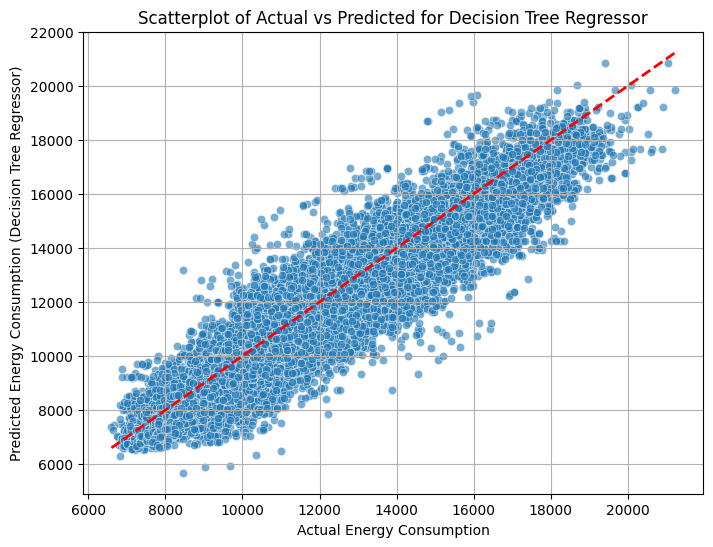

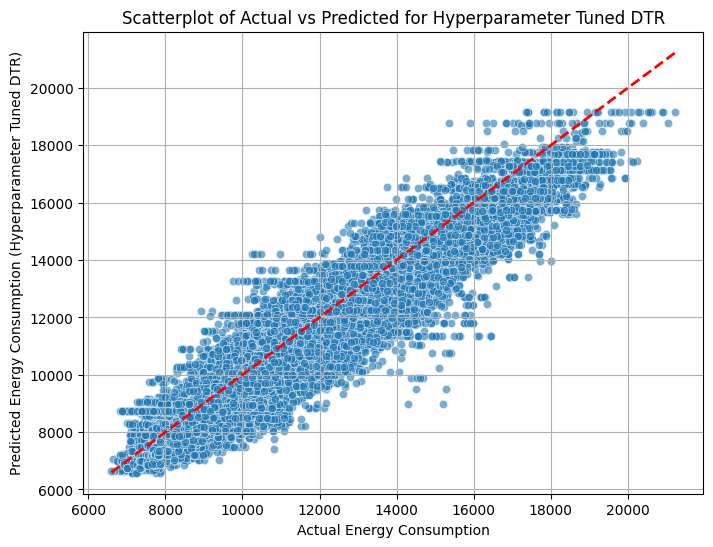

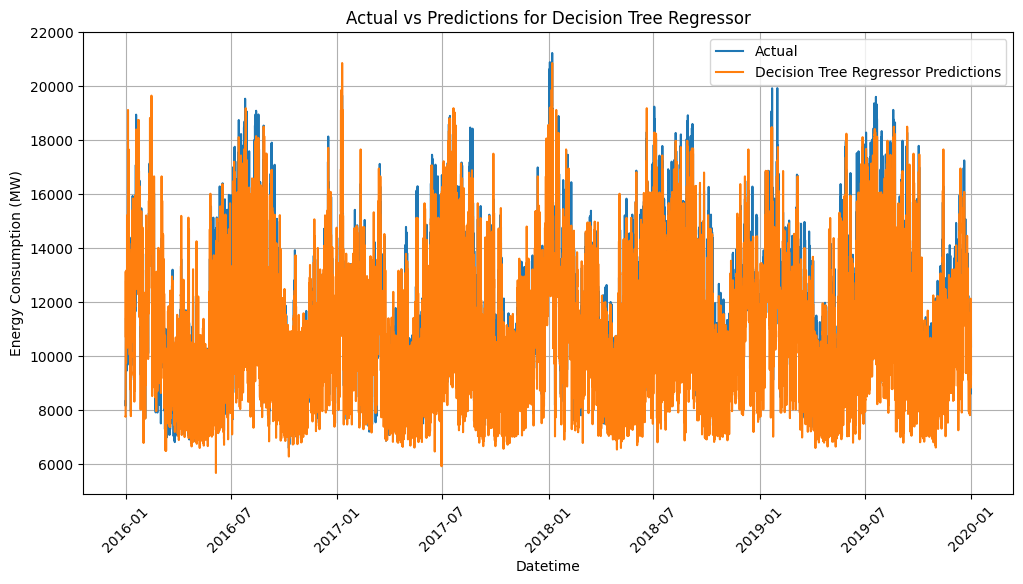

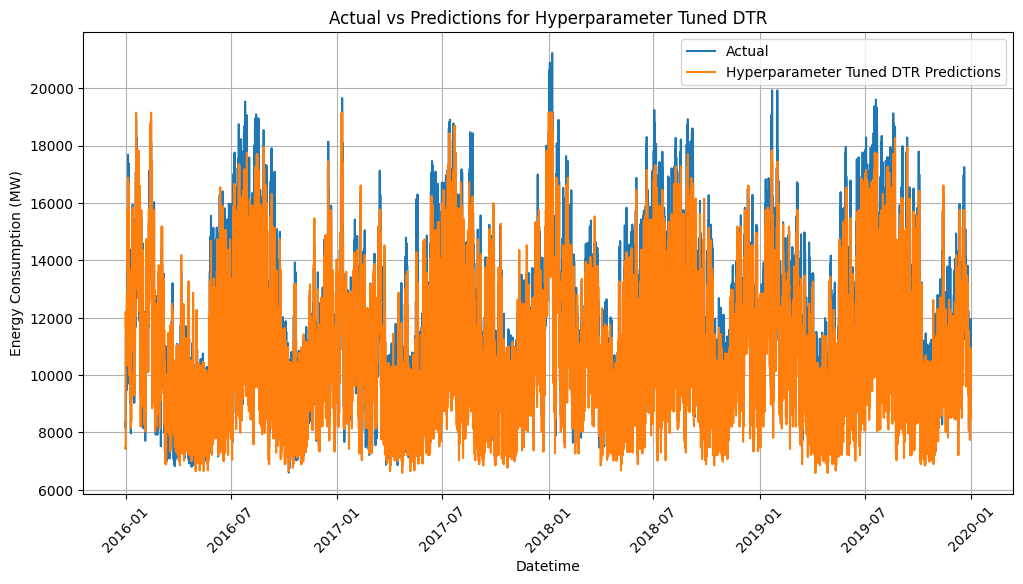

Feature Importance for Decision Tree Regressor:
hour                                            0.362570
tmax_abs_diff_from_room_temperature             0.342235
tavg                                            0.176248
tmin_abs_diff_from_room_temperature             0.029611
dayofweek                                       0.023810
tmin                                            0.014253
dayofyear                                       0.012691
wspd                                            0.008063
year                                            0.006991
weekofyear                                      0.005739
tmax                                            0.005292
dayofmonth                                      0.004619
prcp                                            0.004563
month                                           0.001259
holiday_                                        0.000917
quarter                                         0.000424
holiday_Thanksgiving                    

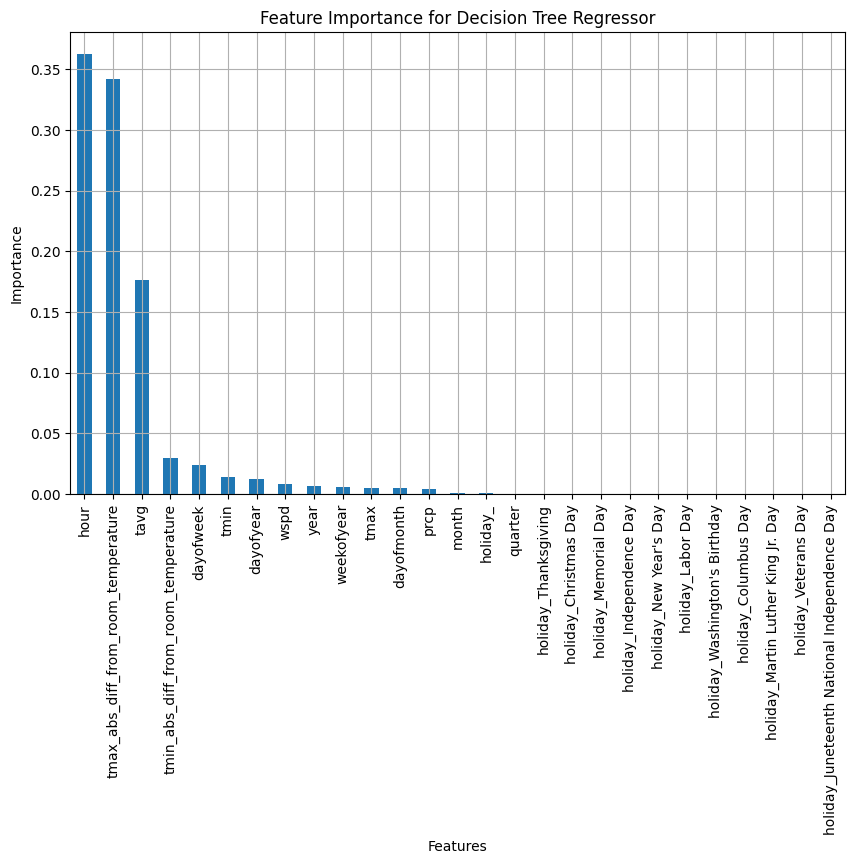

Feature Importance for Hyperparameter Tuned DTR:
hour                                            0.369064
tmax_abs_diff_from_room_temperature             0.352282
tavg                                            0.178943
tmin_abs_diff_from_room_temperature             0.029416
dayofweek                                       0.023044
tmin                                            0.012352
dayofyear                                       0.010199
wspd                                            0.005045
year                                            0.004943
weekofyear                                      0.004708
tmax                                            0.004349
prcp                                            0.002724
dayofmonth                                      0.001933
month                                           0.000460
holiday_                                        0.000333
quarter                                         0.000123
holiday_Christmas Day                  

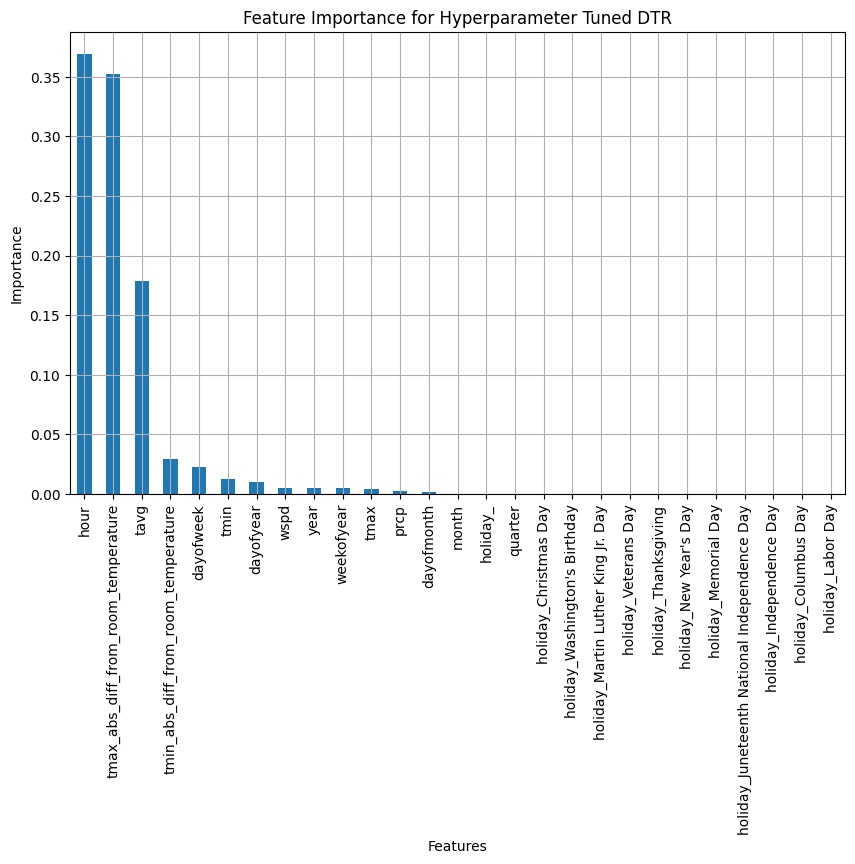

In [34]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from joblib import load
import matplotlib.pyplot as plt
import seaborn as sns

# Load the Decision Tree Regressor models
dtr_all = load('saved models/DTR/dtr_all2019_reg_model.joblib')
dtr_hp = load('saved models/DTR/dtr_best_model_grid_search.joblib')

# List of DTR models for iteration
dtr_models = [
    ('Decision Tree Regressor', dtr_all),
    ('Hyperparameter Tuned DTR', dtr_hp)
]

# Ensure y_test is numeric and handle invalid values
y_test_numeric = pd.to_numeric(y_test, errors='coerce')  # Convert to numeric, set invalid values to NaN
y_test_numeric = y_test_numeric.dropna()  # Drop any NaN values

# Initialize an empty list to store evaluations
dtr_evaluations = []

# Create a DataFrame to store the actuals and predictions
results_df = test[['datetime', 'energy_consumption_mw']].copy()
results_df.columns = ['datetime', 'Actual']  # Rename for clarity

# Evaluate each DTR model
for model_name, model in dtr_models:
    predictions = model.predict(X_test_scaled)
    results_df[model_name + ' Predictions'] = predictions
    
    mae = mean_absolute_error(y_test_numeric, predictions)
    rmse = mean_squared_error(y_test_numeric, predictions, squared=False)
    mape = mean_absolute_percentage_error(y_test_numeric, predictions) * 100
    r2 = r2_score(y_test_numeric, predictions)
    
    dtr_evaluations.append([model_name, mape, mae, rmse, r2])

# Convert DTR evaluations to a DataFrame and export as CSV
dtr_evaluations_df = pd.DataFrame(dtr_evaluations, columns=['Model Name', 'MAPE', 'MAE','RMSE', 'R2'])
dtr_evaluations_df.to_csv('results/dtr_model_evaluations.csv', index=False)

# Export the combined actual vs. predictions CSV for all DTR models
results_df.set_index('datetime', inplace=True)
results_df.to_csv('results/actuals_vs_predictions_combined_dtr.csv')

# Plot scatter plot of True vs Predicted values for each DTR model
for model_name, model in dtr_models:
    predictions = model.predict(X_test_scaled)
    
    # Convert predictions to numeric and remove any non-finite values
    predictions_numeric = pd.to_numeric(predictions, errors='coerce')
    predictions_numeric = predictions_numeric[np.isfinite(predictions_numeric)]
    
    # Ensure both arrays are the same length
    min_len = min(len(y_test_numeric), len(predictions_numeric))
    y_test_numeric_trimmed = y_test_numeric.iloc[:min_len]  # Trim y_test to min length
    predictions_numeric_trimmed = predictions_numeric[:min_len]  # Trim predictions to min length
    
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_test_numeric_trimmed, y=predictions_numeric_trimmed, alpha=0.6)
    
    # Plot a perfect prediction line (y = x)
    plt.plot([y_test_numeric_trimmed.min(), y_test_numeric_trimmed.max()],
             [y_test_numeric_trimmed.min(), y_test_numeric_trimmed.max()],
             color='red', lw=2, linestyle='--')
    
    plt.xlabel('Actual Energy Consumption')
    plt.ylabel(f'Predicted Energy Consumption ({model_name})')
    plt.title(f'Scatterplot of Actual vs Predicted for {model_name}')
    plt.grid(True)
    plt.show()

# Line plot of predictions vs actuals for each model separately
for model_name, model in dtr_models:
    predictions = model.predict(X_test_scaled)
    predictions_numeric = pd.to_numeric(predictions, errors='coerce')
    predictions_numeric = predictions_numeric[np.isfinite(predictions_numeric)]
    
    # Ensure both arrays are the same length
    min_len = min(len(test['datetime']), len(predictions_numeric))
    
    plt.figure(figsize=(12, 6))
    plt.plot(test['datetime'][:min_len], y_test_numeric.iloc[:min_len], label='Actual')
    plt.plot(test['datetime'][:min_len], predictions_numeric[:min_len], label=f'{model_name} Predictions')
    
    plt.xlabel('Datetime')
    plt.ylabel('Energy Consumption (MW)')
    plt.title(f'Actual vs Predictions for {model_name}')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.show()

# Feature importance (coefficients) and plotting for each DTR model
for model_name, model in dtr_models:
    if hasattr(model, 'feature_importances_'):
        feature_importance = pd.Series(model.feature_importances_, index=X_test.columns).sort_values(ascending=False)
        print(f'Feature Importance for {model_name}:')
        print(feature_importance)

        # Plot the feature importance
        plt.figure(figsize=(10, 6))
        feature_importance.plot(kind='bar')
        plt.title(f'Feature Importance for {model_name}')
        plt.xlabel('Features')
        plt.ylabel('Importance')
        plt.grid(True)
        plt.show()
    else:
        print(f"{model_name} does not have a feature importance attribute.")


## Random Forest

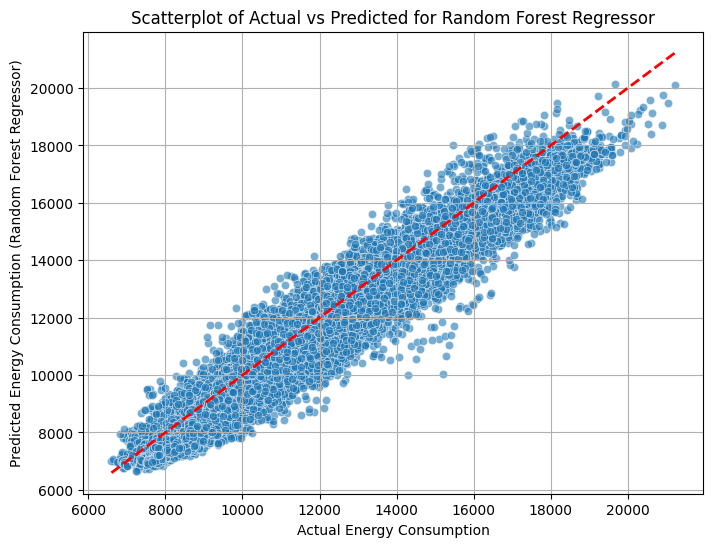

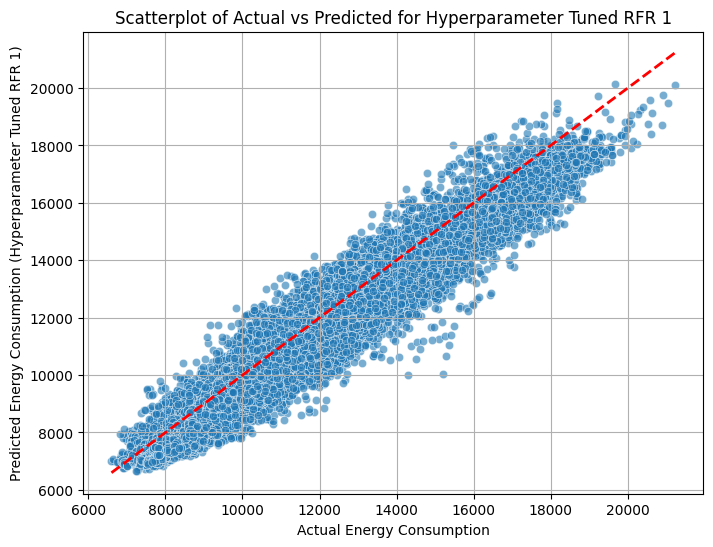

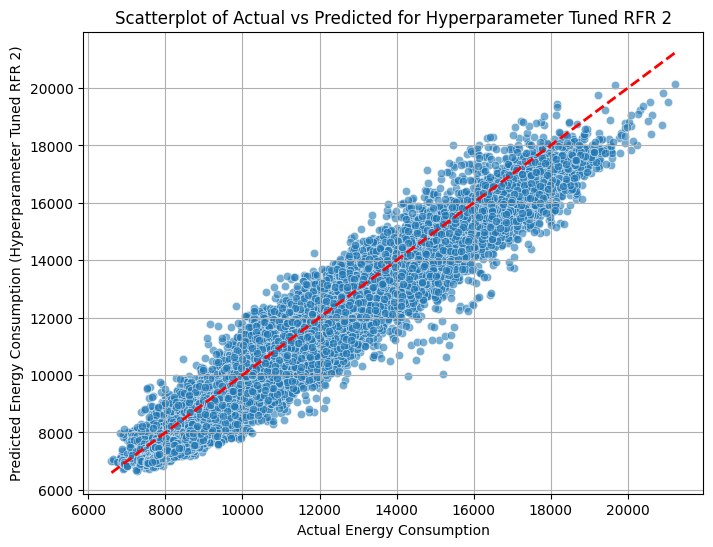

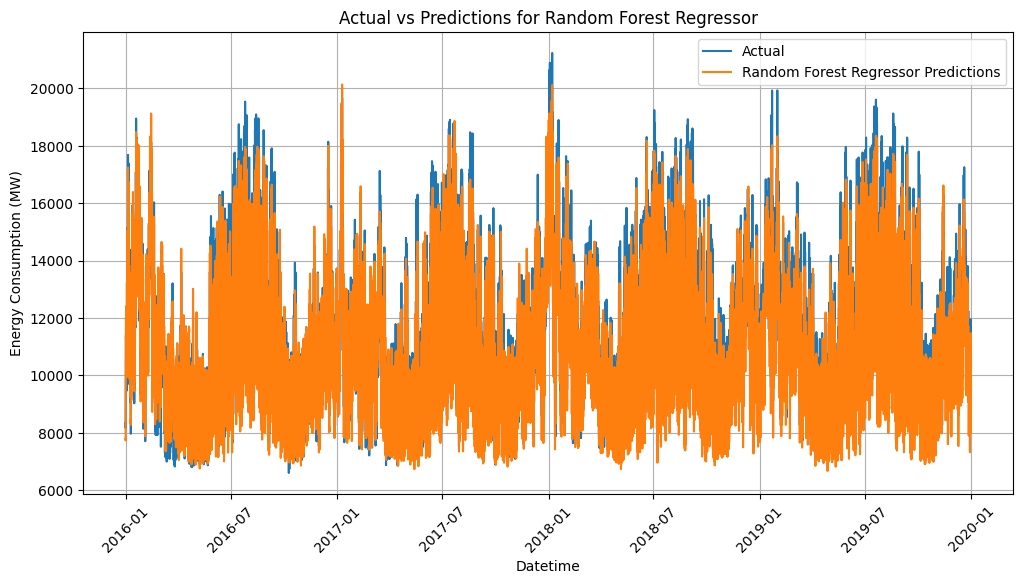

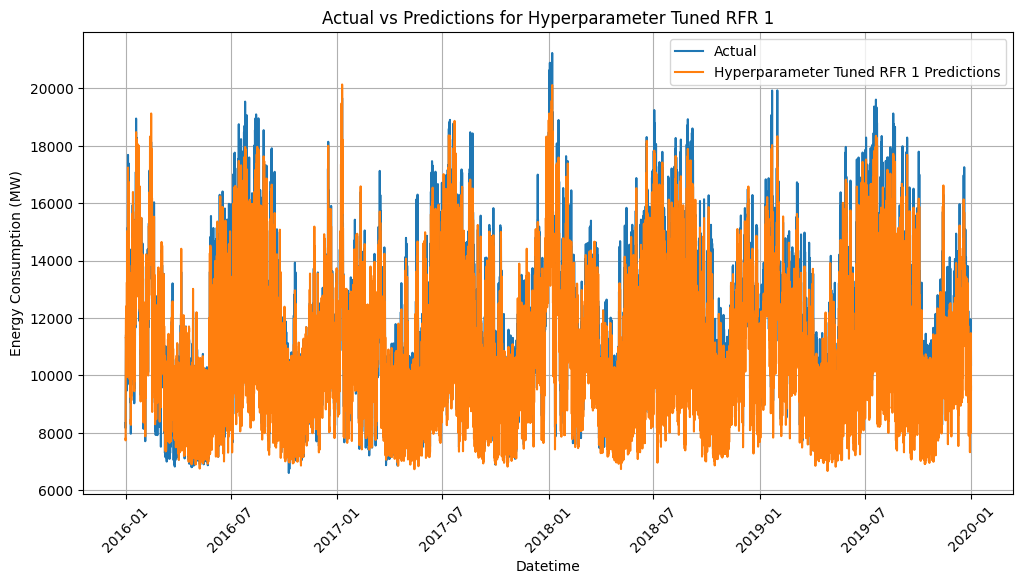

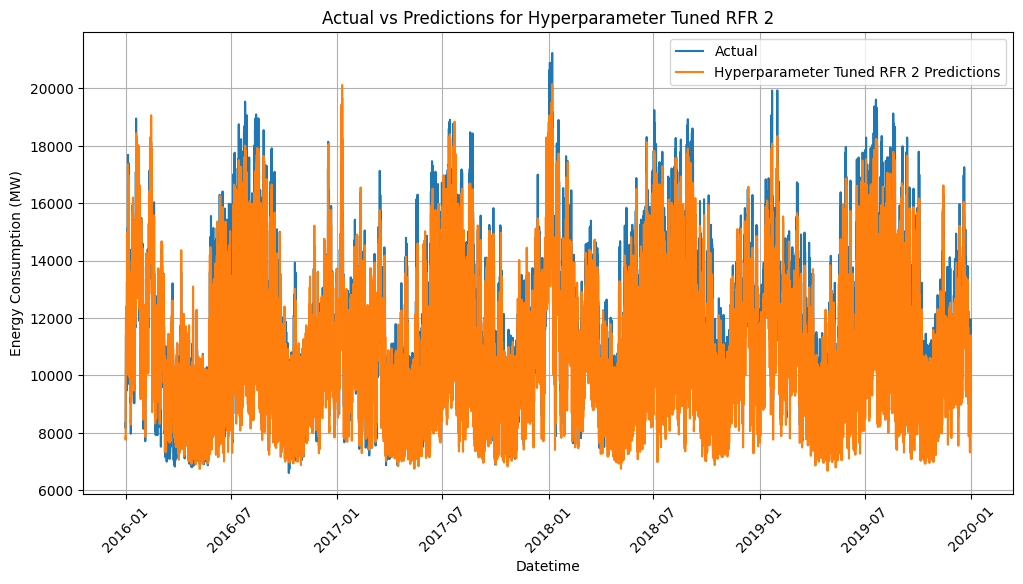

Feature Importance for Random Forest Regressor:
hour                                            0.362399
tmax_abs_diff_from_room_temperature             0.334777
tavg                                            0.181022
dayofweek                                       0.023069
tmin                                            0.020488
tmin_abs_diff_from_room_temperature             0.019680
dayofyear                                       0.013152
tmax                                            0.011707
wspd                                            0.008928
year                                            0.007426
weekofyear                                      0.005541
prcp                                            0.004529
dayofmonth                                      0.004422
month                                           0.001173
holiday_                                        0.000798
quarter                                         0.000337
holiday_Thanksgiving                    

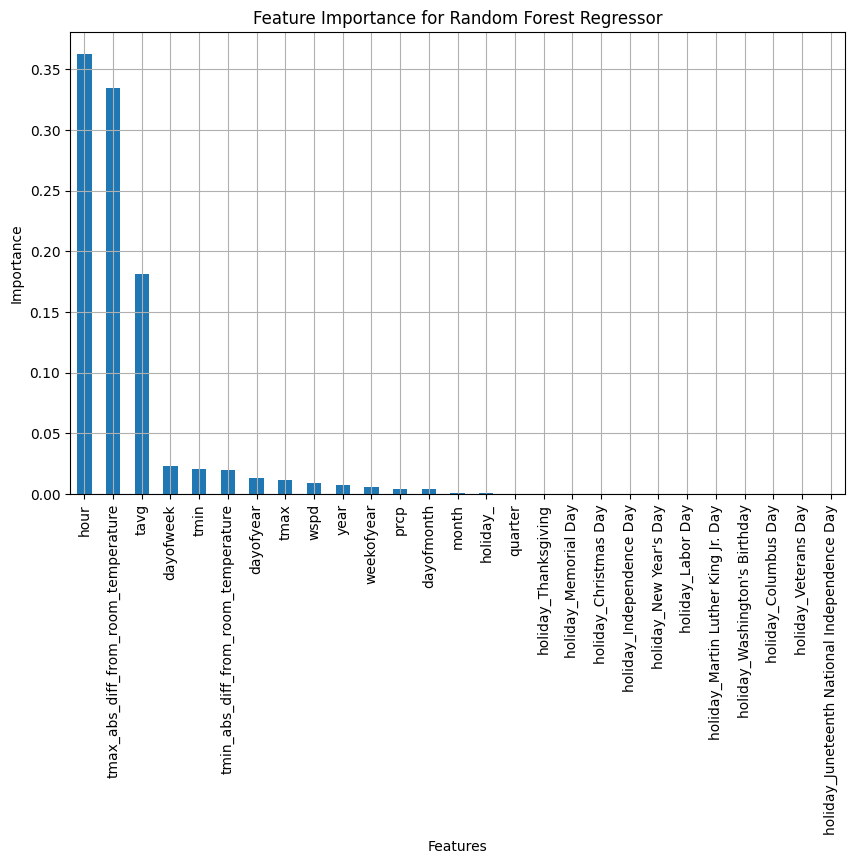

Feature Importance for Hyperparameter Tuned RFR 1:
hour                                            0.362399
tmax_abs_diff_from_room_temperature             0.334777
tavg                                            0.181022
dayofweek                                       0.023069
tmin                                            0.020488
tmin_abs_diff_from_room_temperature             0.019680
dayofyear                                       0.013152
tmax                                            0.011707
wspd                                            0.008928
year                                            0.007426
weekofyear                                      0.005541
prcp                                            0.004529
dayofmonth                                      0.004422
month                                           0.001173
holiday_                                        0.000798
quarter                                         0.000337
holiday_Thanksgiving                 

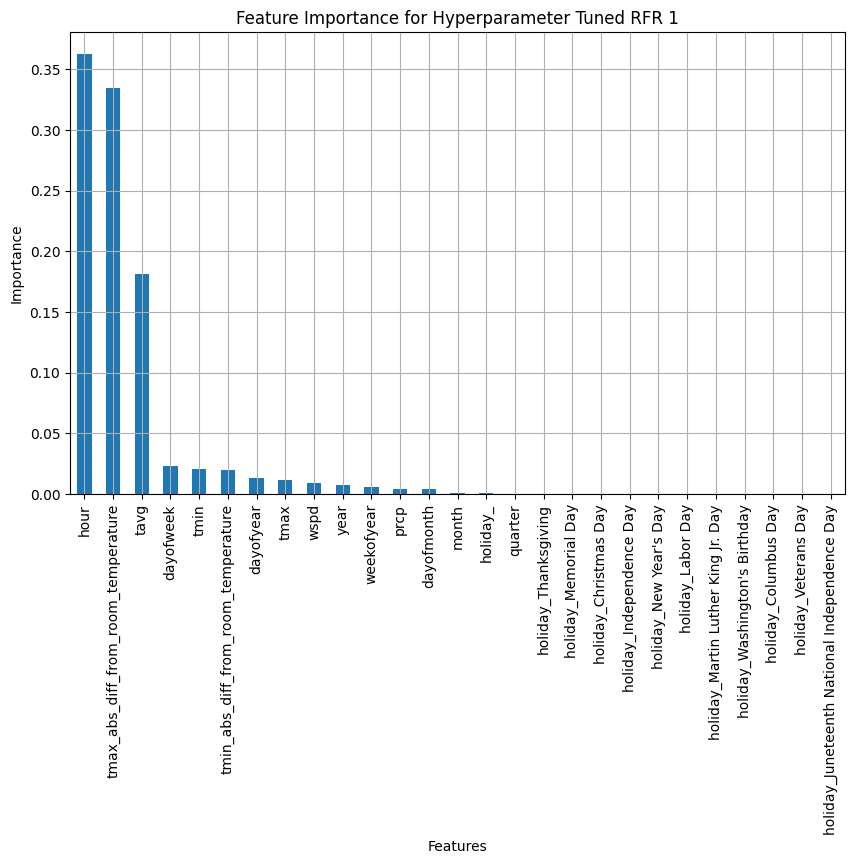

Feature Importance for Hyperparameter Tuned RFR 2:
hour                                            0.362261
tmax_abs_diff_from_room_temperature             0.336131
tavg                                            0.180834
dayofweek                                       0.023092
tmin_abs_diff_from_room_temperature             0.020184
tmin                                            0.019367
dayofyear                                       0.013085
tmax                                            0.011315
wspd                                            0.008870
year                                            0.007444
weekofyear                                      0.005584
prcp                                            0.004519
dayofmonth                                      0.004446
month                                           0.001182
holiday_                                        0.000793
quarter                                         0.000335
holiday_Thanksgiving                 

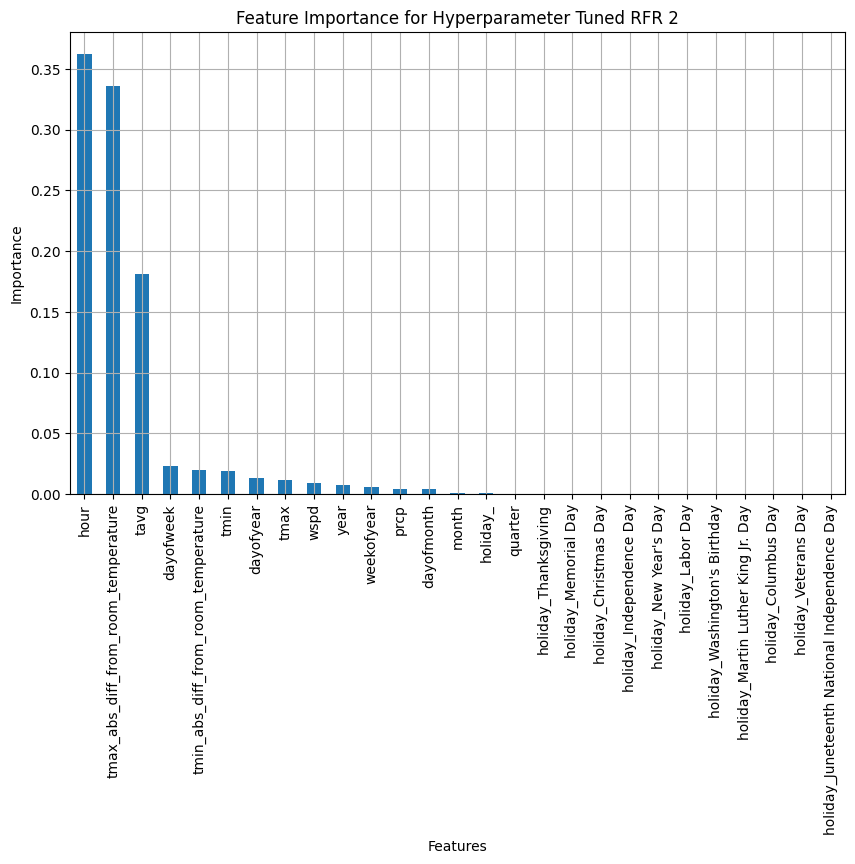

In [35]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from joblib import load
import matplotlib.pyplot as plt
import seaborn as sns

# Load the Random Forest Regressor models
rfr_all = load('saved models/RFR/rfr_all2019_reg_model.joblib')
rfr_hp1 = load('saved models/RFR/rfr_best_model_grid_search.joblib')
rfr_hp2 = load('saved models/RFR/rfr_best_model_grid_search2.joblib')

# List of RFR models for iteration
rfr_models = [
    ('Random Forest Regressor', rfr_all),
    ('Hyperparameter Tuned RFR 1', rfr_hp1),
    ('Hyperparameter Tuned RFR 2', rfr_hp2)
]

# Ensure y_test is numeric and handle invalid values
y_test_numeric = pd.to_numeric(y_test, errors='coerce')  # Convert to numeric, set invalid values to NaN
y_test_numeric = y_test_numeric.dropna()  # Drop any NaN values

# Initialize an empty list to store evaluations
rfr_evaluations = []

# Create a DataFrame to store the actuals and predictions
results_df = test[['datetime', 'energy_consumption_mw']].copy()
results_df.columns = ['datetime', 'Actual']  # Rename for clarity

# Evaluate each RFR model
for model_name, model in rfr_models:
    predictions = model.predict(X_test_scaled)
    results_df[model_name + ' Predictions'] = predictions
    
    mae = mean_absolute_error(y_test_numeric, predictions)
    rmse = mean_squared_error(y_test_numeric, predictions, squared=False)
    mape = mean_absolute_percentage_error(y_test_numeric, predictions) * 100
    r2 = r2_score(y_test_numeric, predictions)
    
    rfr_evaluations.append([model_name, mape, mae, rmse, r2])

# Convert RFR evaluations to a DataFrame and export as CSV
rfr_evaluations_df = pd.DataFrame(rfr_evaluations, columns=['Model Name', 'MAPE', 'MAE','RMSE', 'R2'])
rfr_evaluations_df.to_csv('results/rfr_model_evaluations.csv', index=False)

# Export the combined actual vs. predictions CSV for all RFR models
results_df.set_index('datetime', inplace=True)
results_df.to_csv('results/actuals_vs_predictions_combined_rfr.csv')

# Plot scatter plot of True vs Predicted values for each RFR model
for model_name, model in rfr_models:
    predictions = model.predict(X_test_scaled)
    
    # Convert predictions to numeric and remove any non-finite values
    predictions_numeric = pd.to_numeric(predictions, errors='coerce')
    predictions_numeric = predictions_numeric[np.isfinite(predictions_numeric)]
    
    # Ensure both arrays are the same length
    min_len = min(len(y_test_numeric), len(predictions_numeric))
    y_test_numeric_trimmed = y_test_numeric.iloc[:min_len]  # Trim y_test to min length
    predictions_numeric_trimmed = predictions_numeric[:min_len]  # Trim predictions to min length
    
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_test_numeric_trimmed, y=predictions_numeric_trimmed, alpha=0.6)
    
    # Plot a perfect prediction line (y = x)
    plt.plot([y_test_numeric_trimmed.min(), y_test_numeric_trimmed.max()],
             [y_test_numeric_trimmed.min(), y_test_numeric_trimmed.max()],
             color='red', lw=2, linestyle='--')
    
    plt.xlabel('Actual Energy Consumption')
    plt.ylabel(f'Predicted Energy Consumption ({model_name})')
    plt.title(f'Scatterplot of Actual vs Predicted for {model_name}')
    plt.grid(True)
    plt.show()

# Line plot of predictions vs actuals for each model separately
for model_name, model in rfr_models:
    predictions = model.predict(X_test_scaled)
    predictions_numeric = pd.to_numeric(predictions, errors='coerce')
    predictions_numeric = predictions_numeric[np.isfinite(predictions_numeric)]
    
    # Ensure both arrays are the same length
    min_len = min(len(test['datetime']), len(predictions_numeric))
    
    plt.figure(figsize=(12, 6))
    plt.plot(test['datetime'][:min_len], y_test_numeric.iloc[:min_len], label='Actual')
    plt.plot(test['datetime'][:min_len], predictions_numeric[:min_len], label=f'{model_name} Predictions')
    
    plt.xlabel('Datetime')
    plt.ylabel('Energy Consumption (MW)')
    plt.title(f'Actual vs Predictions for {model_name}')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.show()

# Feature importance (coefficients) and plotting for each RFR model
for model_name, model in rfr_models:
    if hasattr(model, 'feature_importances_'):
        feature_importance = pd.Series(model.feature_importances_, index=X_test.columns).sort_values(ascending=False)
        print(f'Feature Importance for {model_name}:')
        print(feature_importance)

        # Plot the feature importance
        plt.figure(figsize=(10, 6))
        feature_importance.plot(kind='bar')
        plt.title(f'Feature Importance for {model_name}')
        plt.xlabel('Features')
        plt.ylabel('Importance')
        plt.grid(True)
        plt.show()
    else:
        print(f"{model_name} does not have a feature importance attribute.")


## XGBOOST

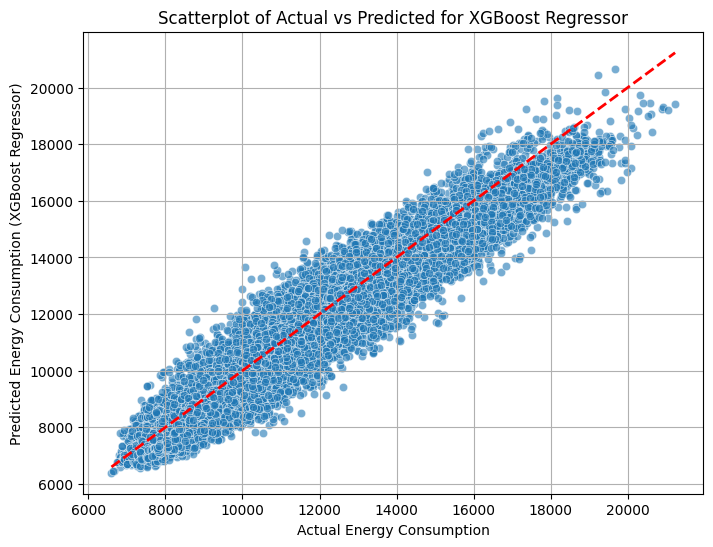

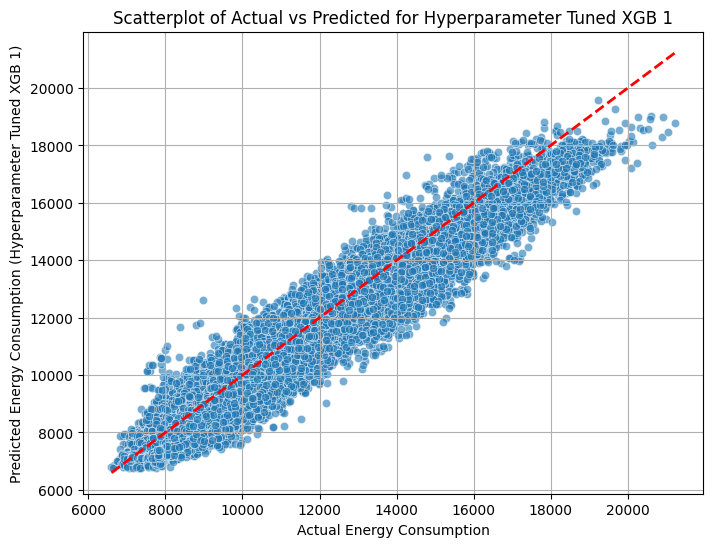

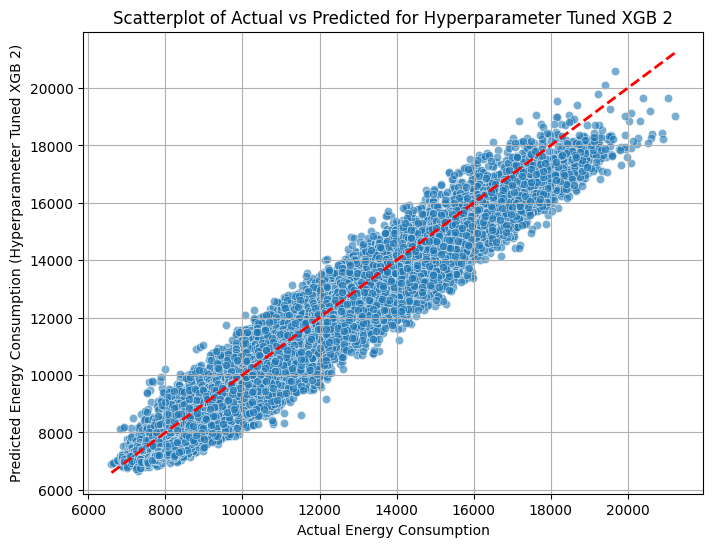

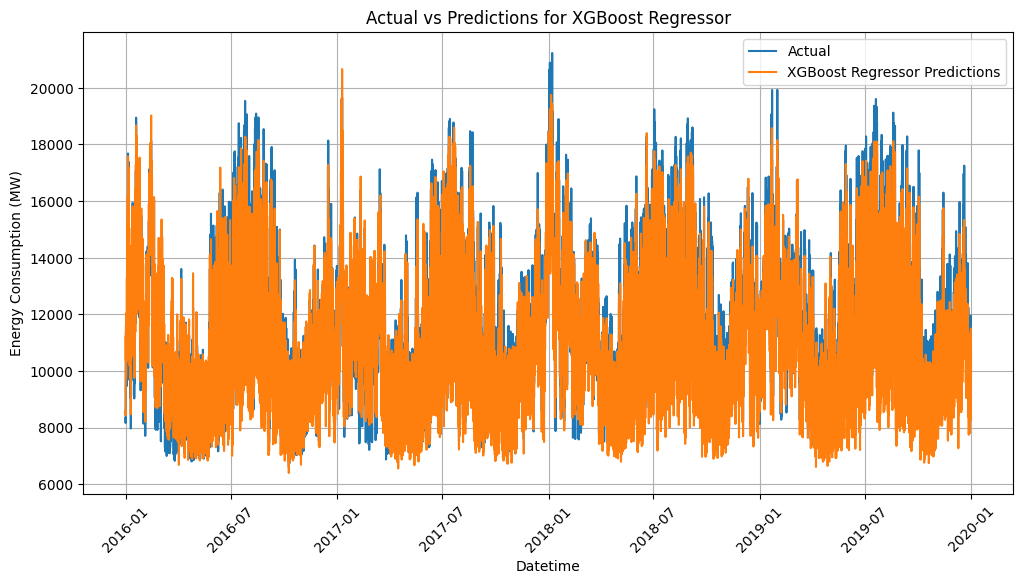

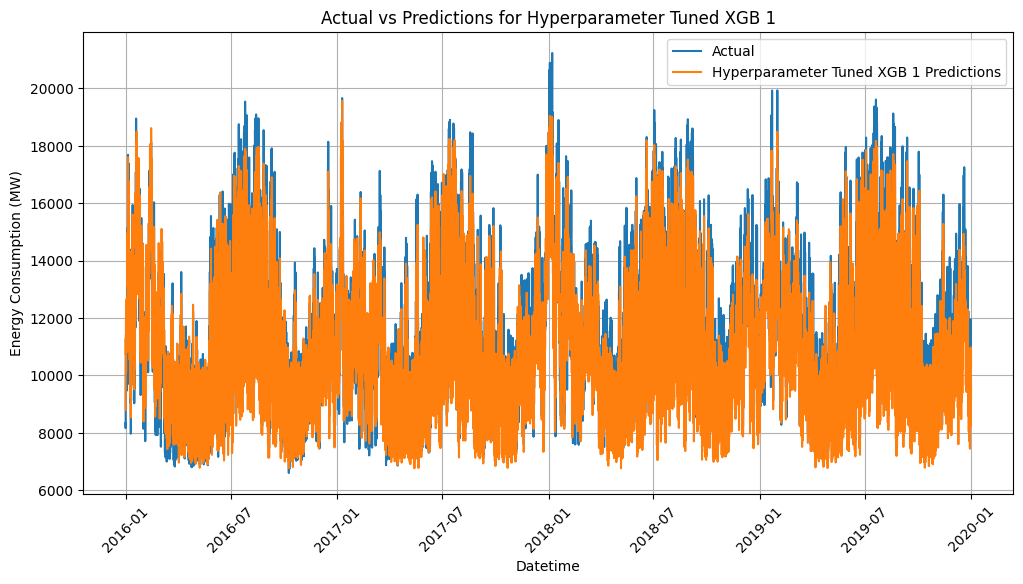

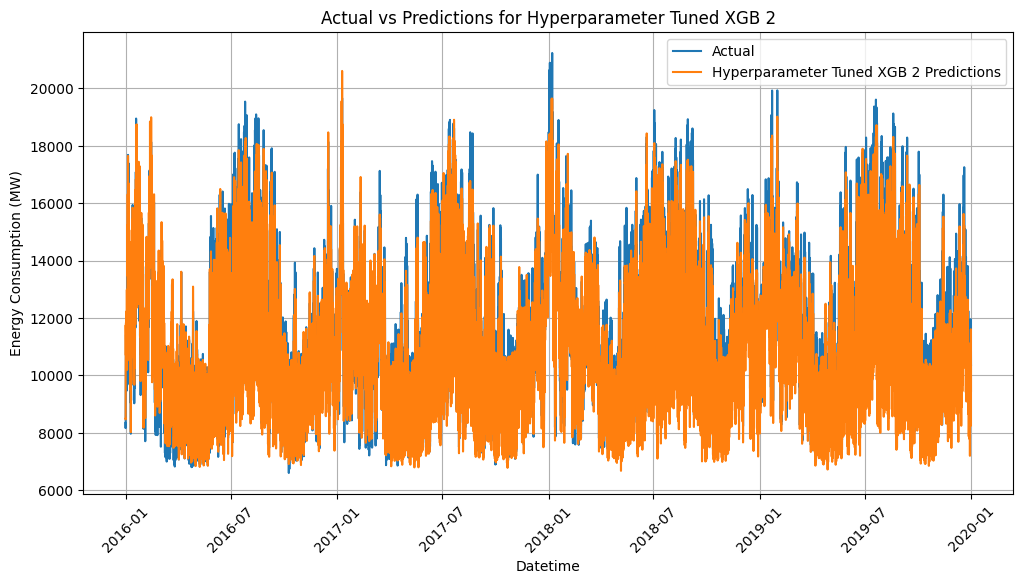

Feature Importance for XGBoost Regressor:
tmax_abs_diff_from_room_temperature             0.752615
tavg                                            0.064826
hour                                            0.055831
tmin                                            0.023277
holiday_                                        0.015363
dayofweek                                       0.012933
tmax                                            0.010216
holiday_Christmas Day                           0.009133
holiday_Veterans Day                            0.008227
dayofyear                                       0.007609
weekofyear                                      0.006049
holiday_Independence Day                        0.006045
year                                            0.005667
month                                           0.004333
wspd                                            0.003506
prcp                                            0.003327
quarter                                       

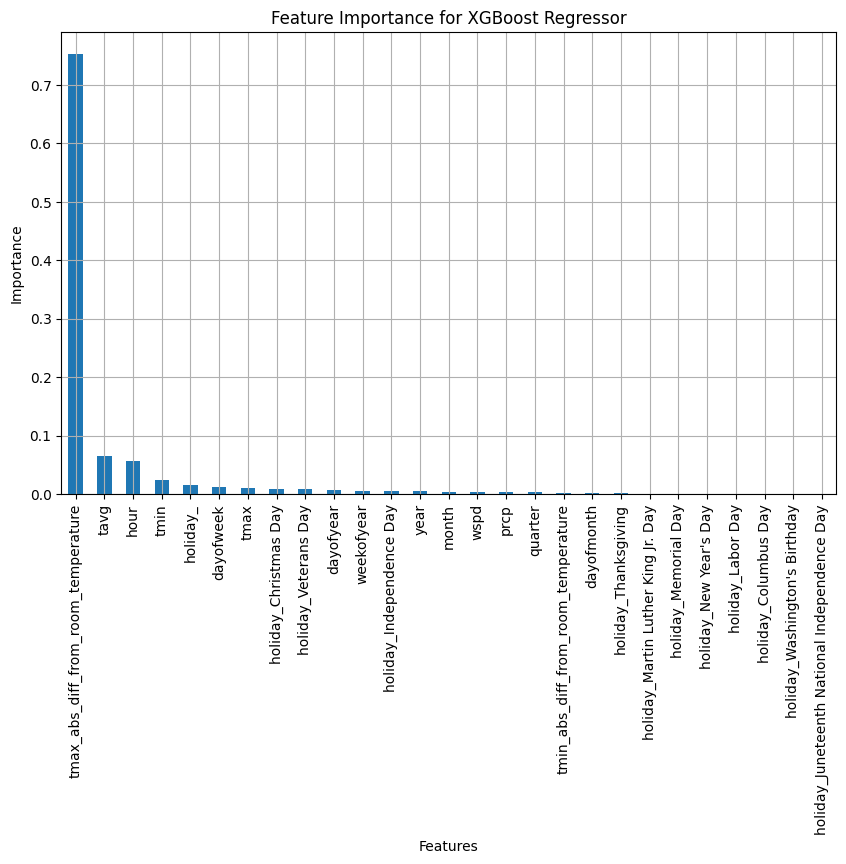

Feature Importance for Hyperparameter Tuned XGB 1:
tmax_abs_diff_from_room_temperature             0.493098
tavg                                            0.183324
hour                                            0.124493
tmin                                            0.043684
dayofweek                                       0.031799
tmin_abs_diff_from_room_temperature             0.029092
tmax                                            0.014170
dayofyear                                       0.011715
year                                            0.010186
holiday_                                        0.009104
quarter                                         0.008950
weekofyear                                      0.007554
month                                           0.006038
holiday_Thanksgiving                            0.004260
holiday_New Year's Day                          0.003912
wspd                                            0.003881
prcp                                 

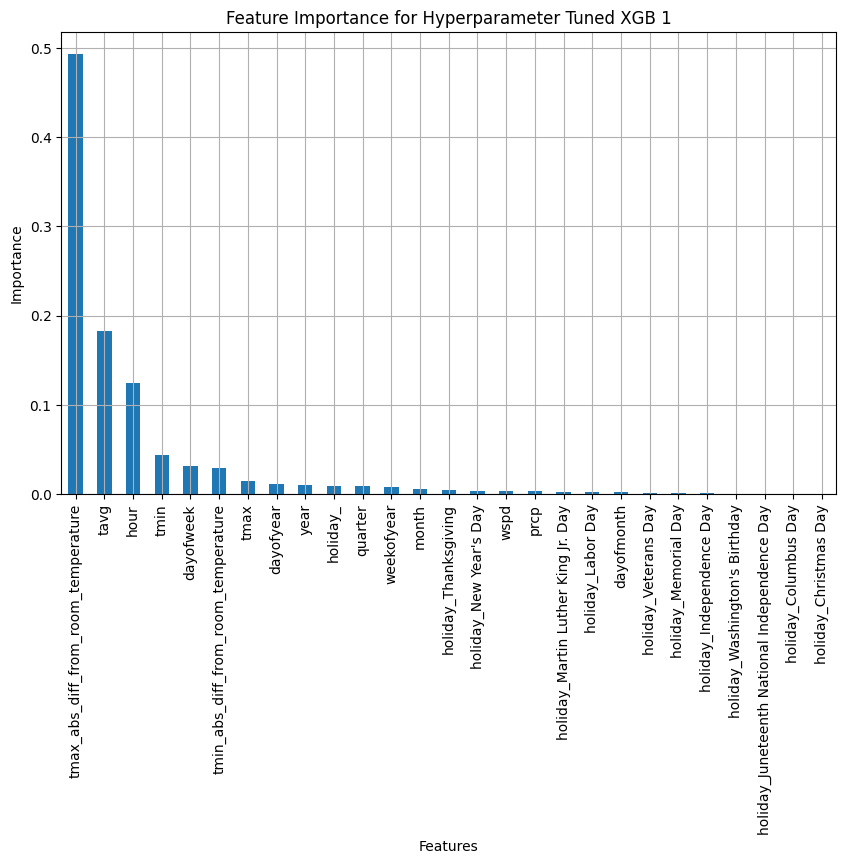

Feature Importance for Hyperparameter Tuned XGB 2:
tmax_abs_diff_from_room_temperature             0.570518
tavg                                            0.148272
hour                                            0.102820
tmin                                            0.034295
dayofweek                                       0.017885
tmin_abs_diff_from_room_temperature             0.016217
tmax                                            0.015636
holiday_                                        0.013468
holiday_Thanksgiving                            0.010339
weekofyear                                      0.008928
dayofyear                                       0.008790
year                                            0.007161
holiday_New Year's Day                          0.006217
holiday_Martin Luther King Jr. Day              0.005131
month                                           0.005075
prcp                                            0.004729
wspd                                 

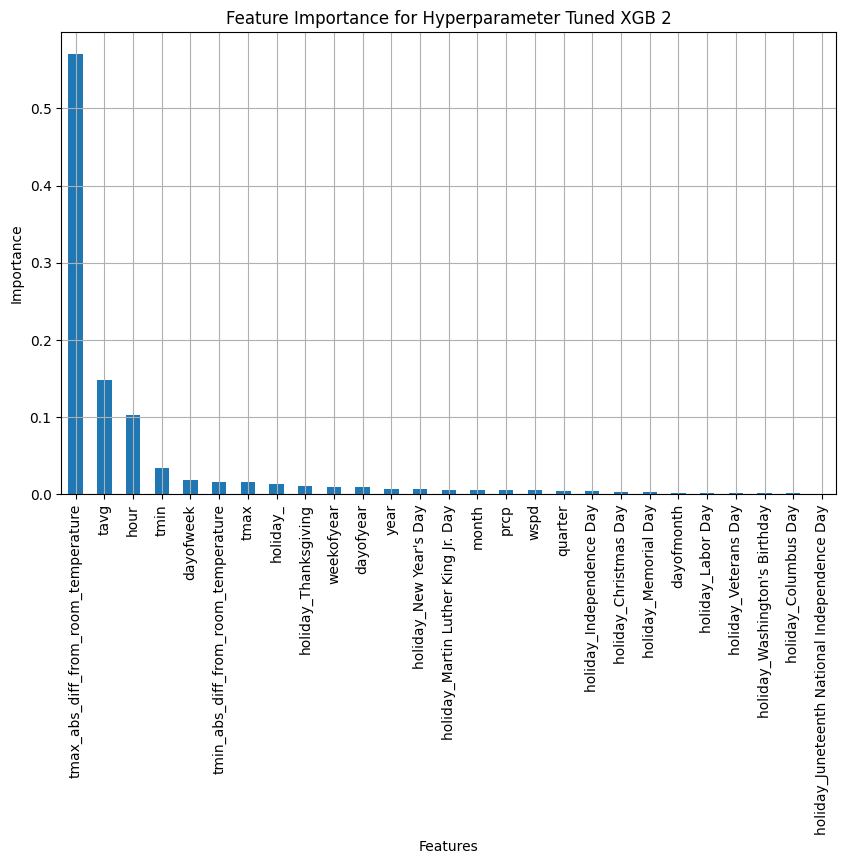

In [36]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from joblib import load
import matplotlib.pyplot as plt
import seaborn as sns

# Load the XGBoost models
xgb_all = load('saved models/XGB/xgb_all2019_reg_model.joblib')
xgb_hp1 = load('saved models/XGB/xgb_best_model_grid_search.joblib')
xgb_hp2 = load('saved models/XGB/xgb_best_model_grid_search2.joblib')

# List of XGBoost models for iteration
xgb_models = [
    ('XGBoost Regressor', xgb_all),
    ('Hyperparameter Tuned XGB 1', xgb_hp1),
    ('Hyperparameter Tuned XGB 2', xgb_hp2)
]

# Ensure y_test is numeric and handle invalid values
y_test_numeric = pd.to_numeric(y_test, errors='coerce')  # Convert to numeric, set invalid values to NaN
y_test_numeric = y_test_numeric.dropna()  # Drop any NaN values

# Initialize an empty list to store evaluations
xgb_evaluations = []

# Create a DataFrame to store the actuals and predictions
results_df = test[['datetime', 'energy_consumption_mw']].copy()
results_df.columns = ['datetime', 'Actual']  # Rename for clarity

# Evaluate each XGB model
for model_name, model in xgb_models:
    predictions = model.predict(X_test_scaled)
    results_df[model_name + ' Predictions'] = predictions
    
    mae = mean_absolute_error(y_test_numeric, predictions)
    rmse = mean_squared_error(y_test_numeric, predictions, squared=False)
    mape = mean_absolute_percentage_error(y_test_numeric, predictions) * 100
    r2 = r2_score(y_test_numeric, predictions)
    
    xgb_evaluations.append([model_name, mape, mae, rmse, r2])

# Convert XGB evaluations to a DataFrame and export as CSV
xgb_evaluations_df = pd.DataFrame(xgb_evaluations, columns=['Model Name', 'MAPE', 'MAE', 'RMSE', 'R2'])
xgb_evaluations_df.to_csv('results/xgb_model_evaluations.csv', index=False)

# Export the combined actual vs. predictions CSV for all XGB models
results_df.set_index('datetime', inplace=True)
results_df.to_csv('results/actuals_vs_predictions_combined_xgb.csv')

# Plot scatter plot of True vs Predicted values for each XGB model
for model_name, model in xgb_models:
    predictions = model.predict(X_test_scaled)
    
    # Convert predictions to numeric and remove any non-finite values
    predictions_numeric = pd.to_numeric(predictions, errors='coerce')
    predictions_numeric = predictions_numeric[np.isfinite(predictions_numeric)]
    
    # Ensure both arrays are the same length
    min_len = min(len(y_test_numeric), len(predictions_numeric))
    y_test_numeric_trimmed = y_test_numeric.iloc[:min_len]  # Trim y_test to min length
    predictions_numeric_trimmed = predictions_numeric[:min_len]  # Trim predictions to min length
    
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_test_numeric_trimmed, y=predictions_numeric_trimmed, alpha=0.6)
    
    # Plot a perfect prediction line (y = x)
    plt.plot([y_test_numeric_trimmed.min(), y_test_numeric_trimmed.max()],
             [y_test_numeric_trimmed.min(), y_test_numeric_trimmed.max()],
             color='red', lw=2, linestyle='--')
    
    plt.xlabel('Actual Energy Consumption')
    plt.ylabel(f'Predicted Energy Consumption ({model_name})')
    plt.title(f'Scatterplot of Actual vs Predicted for {model_name}')
    plt.grid(True)
    plt.show()

# Line plot of predictions vs actuals for each model separately
for model_name, model in xgb_models:
    predictions = model.predict(X_test_scaled)
    predictions_numeric = pd.to_numeric(predictions, errors='coerce')
    predictions_numeric = predictions_numeric[np.isfinite(predictions_numeric)]
    
    # Ensure both arrays are the same length
    min_len = min(len(test['datetime']), len(predictions_numeric))
    
    plt.figure(figsize=(12, 6))
    plt.plot(test['datetime'][:min_len], y_test_numeric.iloc[:min_len], label='Actual')
    plt.plot(test['datetime'][:min_len], predictions_numeric[:min_len], label=f'{model_name} Predictions')
    
    plt.xlabel('Datetime')
    plt.ylabel('Energy Consumption (MW)')
    plt.title(f'Actual vs Predictions for {model_name}')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.show()

# Feature importance (coefficients) and plotting for each XGB model
for model_name, model in xgb_models:
    if hasattr(model, 'feature_importances_'):
        feature_importance = pd.Series(model.feature_importances_, index=X_test.columns).sort_values(ascending=False)
        print(f'Feature Importance for {model_name}:')
        print(feature_importance)

        # Plot the feature importance
        plt.figure(figsize=(10, 6))
        feature_importance.plot(kind='bar')
        plt.title(f'Feature Importance for {model_name}')
        plt.xlabel('Features')
        plt.ylabel('Importance')
        plt.grid(True)
        plt.show()
    else:
        print(f"{model_name} does not have a feature importance attribute.")


## GB

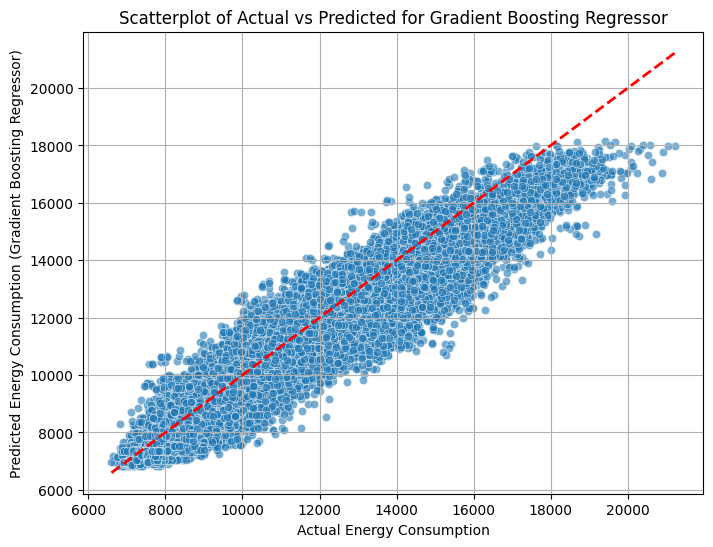

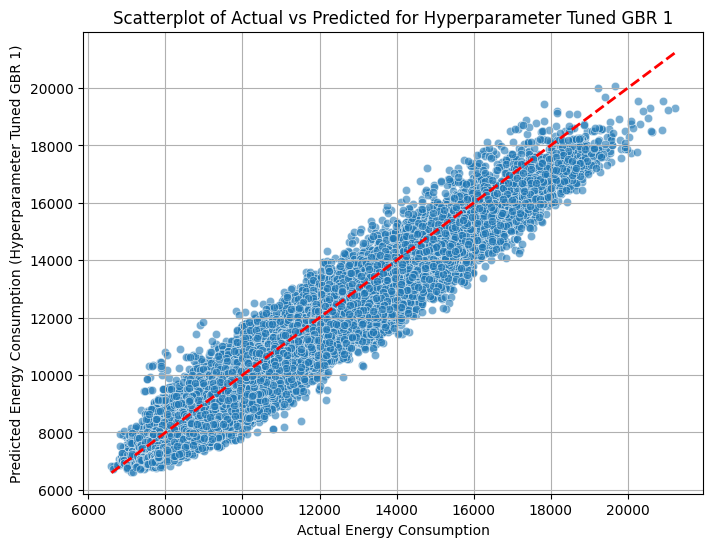

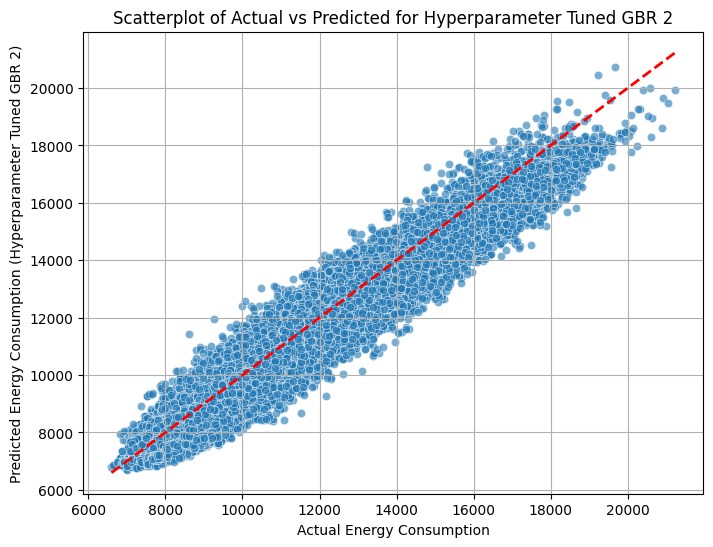

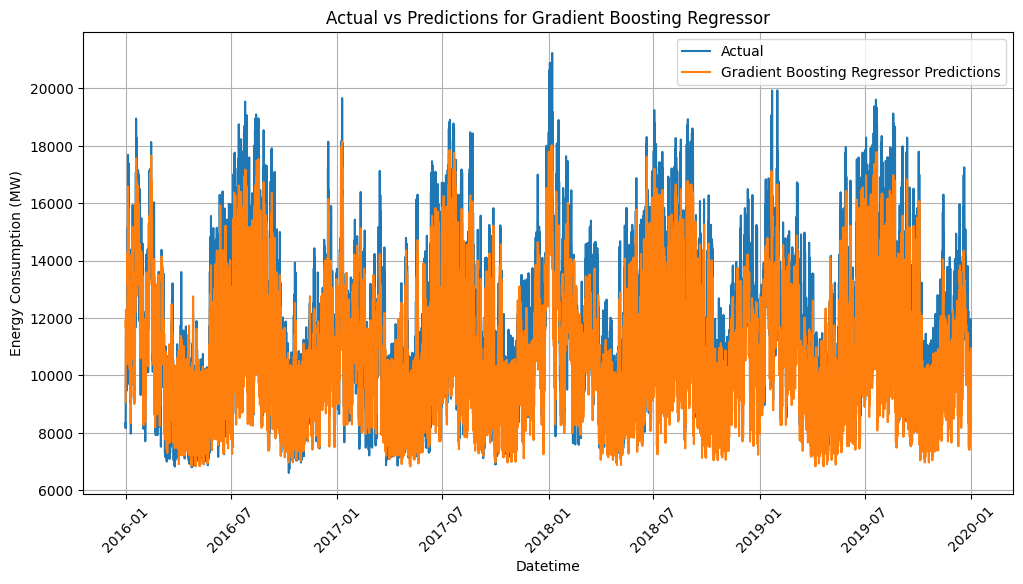

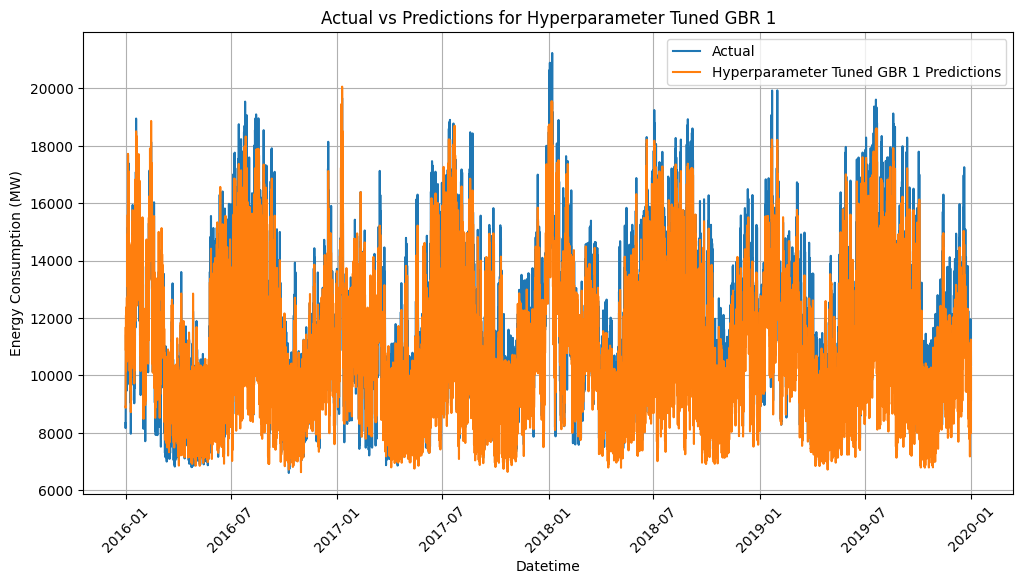

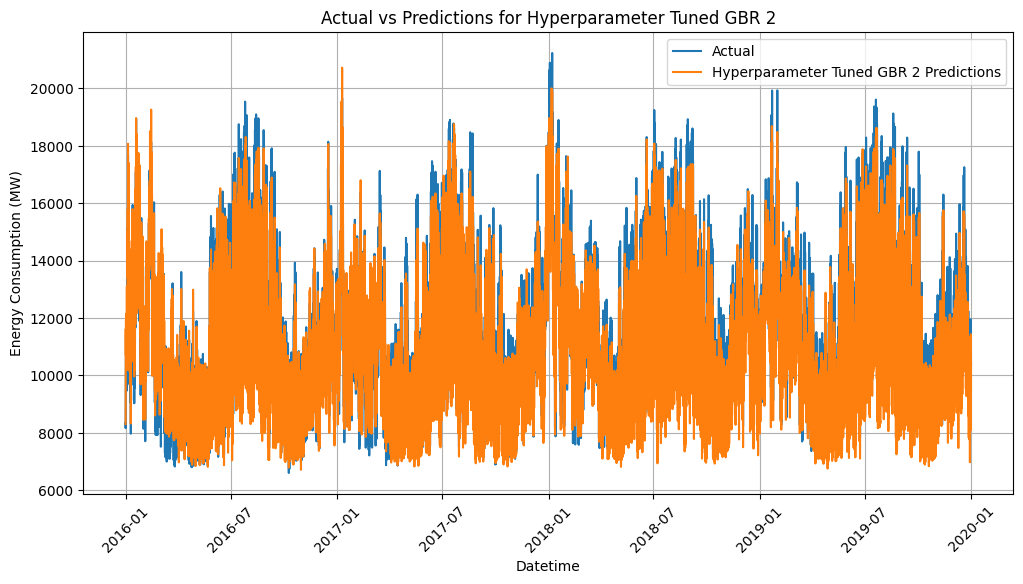

Feature Importance for Gradient Boosting Regressor:
hour                                            0.365885
tmax_abs_diff_from_room_temperature             0.357888
tavg                                            0.155358
tmin                                            0.063444
dayofweek                                       0.017617
tmin_abs_diff_from_room_temperature             0.015124
dayofyear                                       0.014538
year                                            0.004015
tmax                                            0.003315
holiday_                                        0.000864
weekofyear                                      0.000820
quarter                                         0.000398
wspd                                            0.000348
month                                           0.000195
dayofmonth                                      0.000126
prcp                                            0.000030
holiday_Martin Luther King Jr. Day  

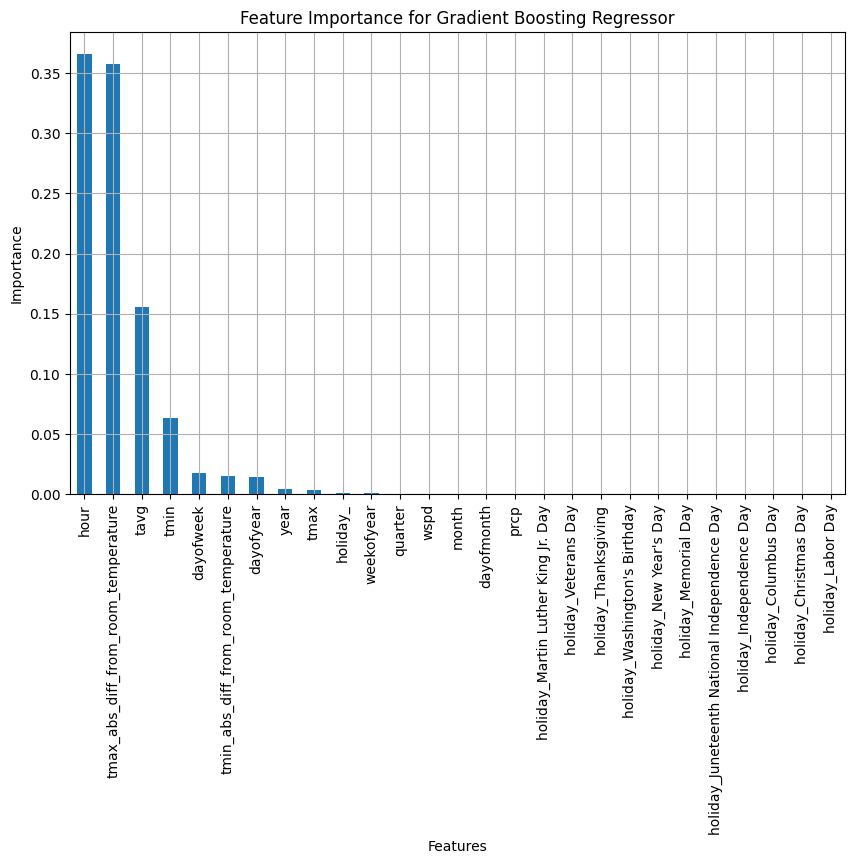

Feature Importance for Hyperparameter Tuned GBR 1:
hour                                            3.699992e-01
tmax_abs_diff_from_room_temperature             3.367372e-01
tavg                                            1.761385e-01
tmin                                            3.825243e-02
dayofweek                                       1.971978e-02
dayofyear                                       1.655563e-02
tmin_abs_diff_from_room_temperature             1.495298e-02
tmax                                            1.035868e-02
year                                            7.099917e-03
wspd                                            4.173541e-03
prcp                                            2.064146e-03
weekofyear                                      1.575213e-03
holiday_                                        9.101927e-04
dayofmonth                                      8.145267e-04
month                                           3.280319e-04
quarter                           

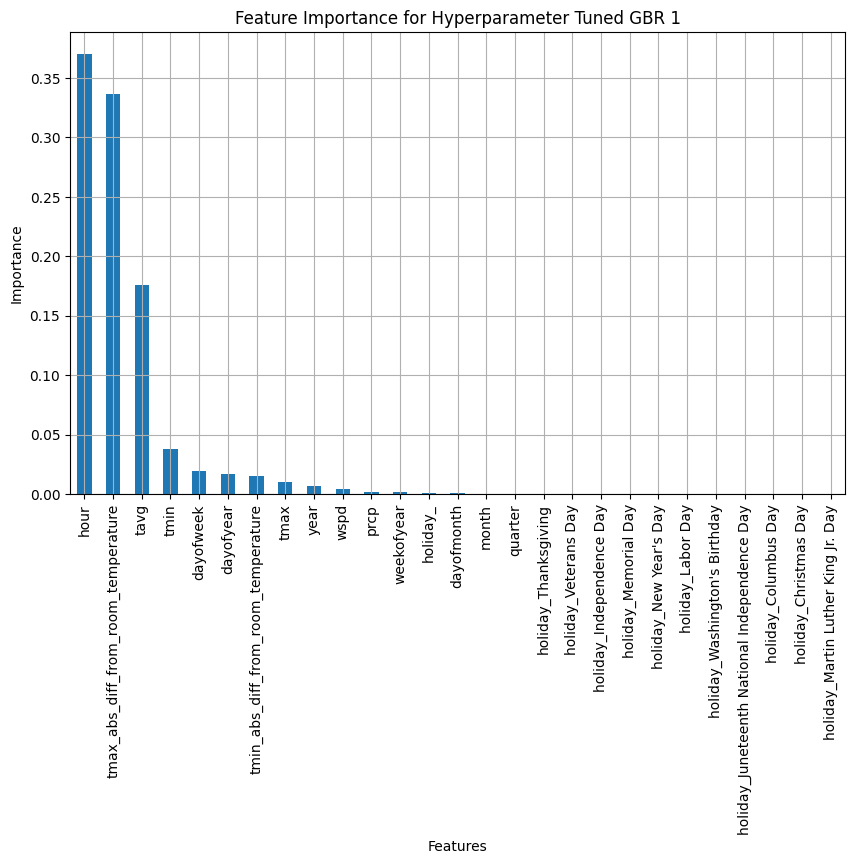

Feature Importance for Hyperparameter Tuned GBR 2:
hour                                            0.372443
tmax_abs_diff_from_room_temperature             0.334295
tavg                                            0.181968
tmin                                            0.029452
dayofweek                                       0.021895
dayofyear                                       0.015764
tmin_abs_diff_from_room_temperature             0.010095
tmax                                            0.008801
year                                            0.007765
wspd                                            0.006671
prcp                                            0.003787
weekofyear                                      0.003622
dayofmonth                                      0.001595
holiday_                                        0.001105
month                                           0.000257
quarter                                         0.000209
holiday_Thanksgiving                 

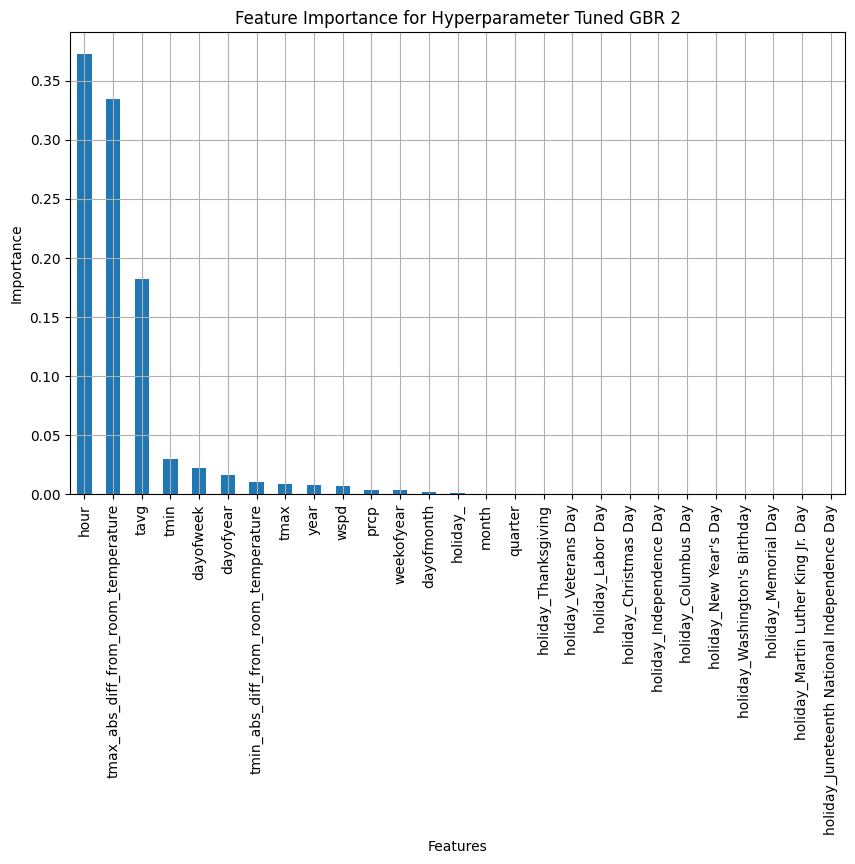

In [37]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from joblib import load
import matplotlib.pyplot as plt
import seaborn as sns

# Load the Gradient Boosting models
gbr_all = load('saved models/GBR/gbr_all2019_reg_model.joblib')
gbr_hp1 = load('saved models/GBR/gbr_best_model_grid_search.joblib')
gbr_hp2 = load('saved models/GBR/gbr_best_model_grid_search2.joblib')

# List of GBR models for iteration
gbr_models = [
    ('Gradient Boosting Regressor', gbr_all),
    ('Hyperparameter Tuned GBR 1', gbr_hp1),
    ('Hyperparameter Tuned GBR 2', gbr_hp2)
]

# Ensure y_test is numeric and handle invalid values
y_test_numeric = pd.to_numeric(y_test, errors='coerce')  # Convert to numeric, set invalid values to NaN
y_test_numeric = y_test_numeric.dropna()  # Drop any NaN values

# Initialize an empty list to store evaluations
gbr_evaluations = []

# Create a DataFrame to store the actuals and predictions
results_df = test[['datetime', 'energy_consumption_mw']].copy()
results_df.columns = ['datetime', 'Actual']  # Rename for clarity

# Evaluate each GBR model
for model_name, model in gbr_models:
    predictions = model.predict(X_test_scaled)
    results_df[model_name + ' Predictions'] = predictions
    
    mae = mean_absolute_error(y_test_numeric, predictions)
    rmse = mean_squared_error(y_test_numeric, predictions, squared=False)
    mape = mean_absolute_percentage_error(y_test_numeric, predictions) * 100
    r2 = r2_score(y_test_numeric, predictions)
    
    gbr_evaluations.append([model_name, mape, mae, rmse, r2])

# Convert GBR evaluations to a DataFrame and export as CSV
gbr_evaluations_df = pd.DataFrame(gbr_evaluations, columns=['Model Name', 'MAPE', 'MAE','RMSE', 'R2'])
gbr_evaluations_df.to_csv('results/gbr_model_evaluations.csv', index=False)

# Export the combined actual vs. predictions CSV for all GBR models
results_df.set_index('datetime', inplace=True)
results_df.to_csv('results/actuals_vs_predictions_combined_gbr.csv')

# Plot scatter plot of True vs Predicted values for each GBR model
for model_name, model in gbr_models:
    predictions = model.predict(X_test_scaled)
    
    # Convert predictions to numeric and remove any non-finite values
    predictions_numeric = pd.to_numeric(predictions, errors='coerce')
    predictions_numeric = predictions_numeric[np.isfinite(predictions_numeric)]
    
    # Ensure both arrays are the same length
    min_len = min(len(y_test_numeric), len(predictions_numeric))
    y_test_numeric_trimmed = y_test_numeric.iloc[:min_len]  # Trim y_test to min length
    predictions_numeric_trimmed = predictions_numeric[:min_len]  # Trim predictions to min length
    
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_test_numeric_trimmed, y=predictions_numeric_trimmed, alpha=0.6)
    
    # Plot a perfect prediction line (y = x)
    plt.plot([y_test_numeric_trimmed.min(), y_test_numeric_trimmed.max()],
             [y_test_numeric_trimmed.min(), y_test_numeric_trimmed.max()],
             color='red', lw=2, linestyle='--')
    
    plt.xlabel('Actual Energy Consumption')
    plt.ylabel(f'Predicted Energy Consumption ({model_name})')
    plt.title(f'Scatterplot of Actual vs Predicted for {model_name}')
    plt.grid(True)
    plt.show()

# Line plot of predictions vs actuals for each model separately
for model_name, model in gbr_models:
    predictions = model.predict(X_test_scaled)
    predictions_numeric = pd.to_numeric(predictions, errors='coerce')
    predictions_numeric = predictions_numeric[np.isfinite(predictions_numeric)]
    
    # Ensure both arrays are the same length
    min_len = min(len(test['datetime']), len(predictions_numeric))
    
    plt.figure(figsize=(12, 6))
    plt.plot(test['datetime'][:min_len], y_test_numeric.iloc[:min_len], label='Actual')
    plt.plot(test['datetime'][:min_len], predictions_numeric[:min_len], label=f'{model_name} Predictions')
    
    plt.xlabel('Datetime')
    plt.ylabel('Energy Consumption (MW)')
    plt.title(f'Actual vs Predictions for {model_name}')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.show()

# Feature importance and plotting for each GBR model
for model_name, model in gbr_models:
    if hasattr(model, 'feature_importances_'):
        feature_importance = pd.Series(model.feature_importances_, index=X_test.columns).sort_values(ascending=False)
        print(f'Feature Importance for {model_name}:')
        print(feature_importance)

        # Plot the feature importance
        plt.figure(figsize=(10, 6))
        feature_importance.plot(kind='bar')
        plt.title(f'Feature Importance for {model_name}')
        plt.xlabel('Features')
        plt.ylabel('Importance')
        plt.grid(True)
        plt.show()
    else:
        print(f"{model_name} does not have a feature importance attribute.")


## Ensemble Learning

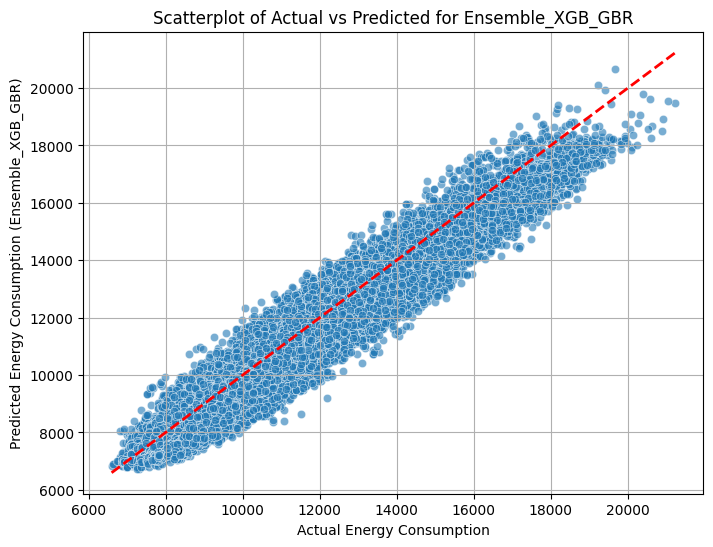

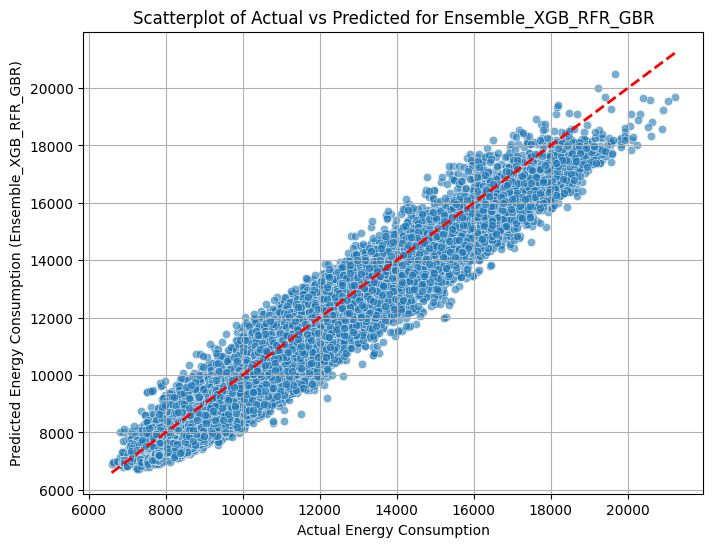

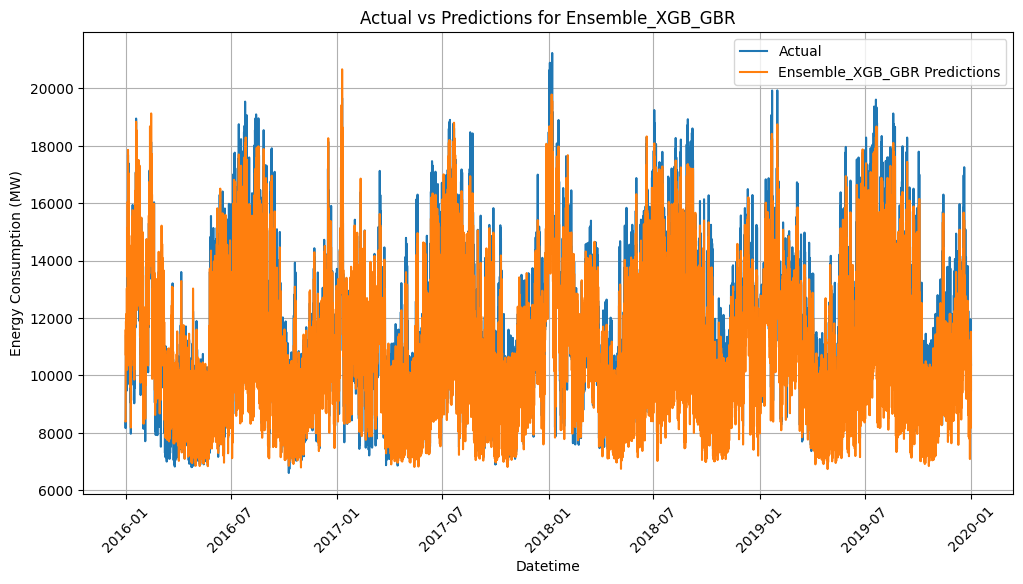

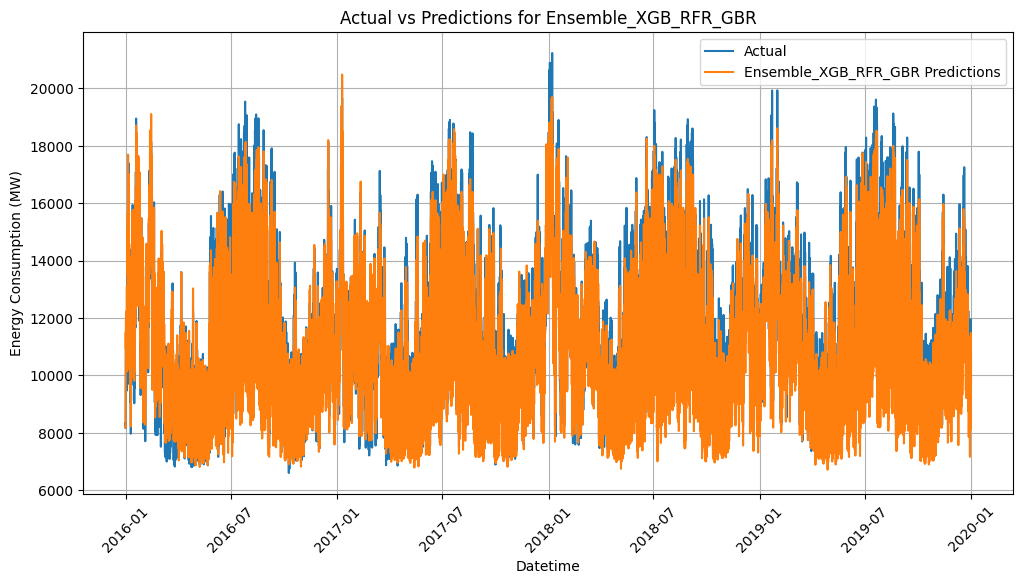

Feature Importance for Ensemble_XGB_GBR is model dependent, retrieving individual model importances...
Feature Importance for Estimator_1 in Ensemble_XGB_GBR:
tmax_abs_diff_from_room_temperature             0.570518
tavg                                            0.148272
hour                                            0.102820
tmin                                            0.034295
dayofweek                                       0.017885
tmin_abs_diff_from_room_temperature             0.016217
tmax                                            0.015636
holiday_                                        0.013468
holiday_Thanksgiving                            0.010339
weekofyear                                      0.008928
dayofyear                                       0.008790
year                                            0.007161
holiday_New Year's Day                          0.006217
holiday_Martin Luther King Jr. Day              0.005131
month                                      

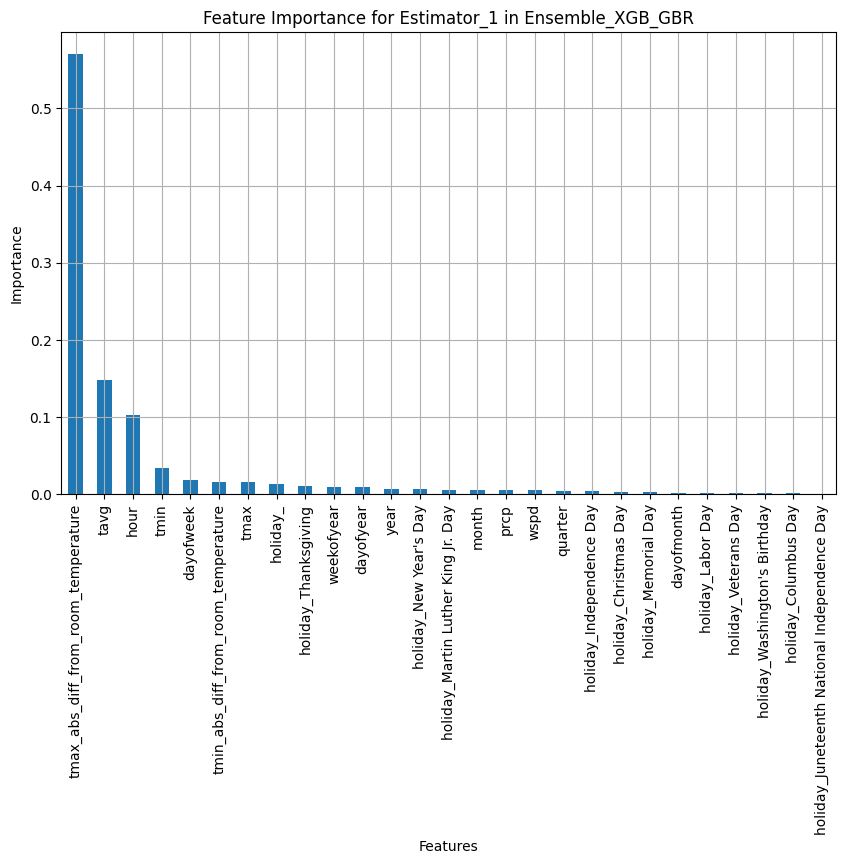

Feature Importance for Estimator_2 in Ensemble_XGB_GBR:
hour                                            0.372443
tmax_abs_diff_from_room_temperature             0.334295
tavg                                            0.181968
tmin                                            0.029452
dayofweek                                       0.021895
dayofyear                                       0.015764
tmin_abs_diff_from_room_temperature             0.010095
tmax                                            0.008801
year                                            0.007765
wspd                                            0.006671
prcp                                            0.003787
weekofyear                                      0.003622
dayofmonth                                      0.001595
holiday_                                        0.001105
month                                           0.000257
quarter                                         0.000209
holiday_Thanksgiving            

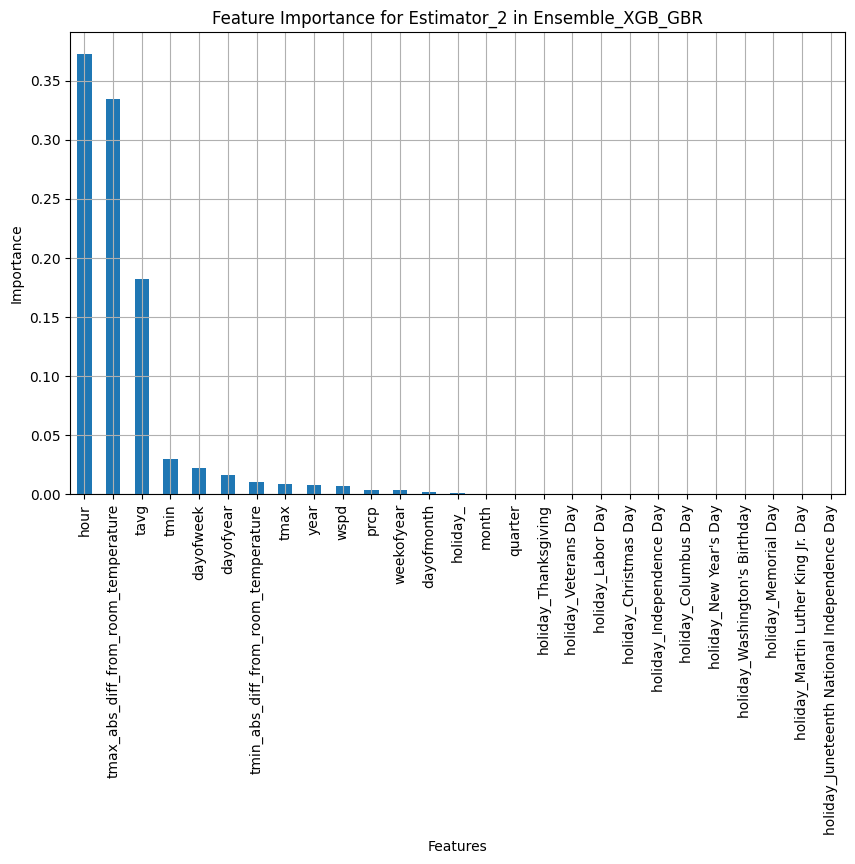

Feature Importance for Ensemble_XGB_RFR_GBR is model dependent, retrieving individual model importances...
Feature Importance for Estimator_1 in Ensemble_XGB_RFR_GBR:
tmax_abs_diff_from_room_temperature             0.570518
tavg                                            0.148272
hour                                            0.102820
tmin                                            0.034295
dayofweek                                       0.017885
tmin_abs_diff_from_room_temperature             0.016217
tmax                                            0.015636
holiday_                                        0.013468
holiday_Thanksgiving                            0.010339
weekofyear                                      0.008928
dayofyear                                       0.008790
year                                            0.007161
holiday_New Year's Day                          0.006217
holiday_Martin Luther King Jr. Day              0.005131
month                              

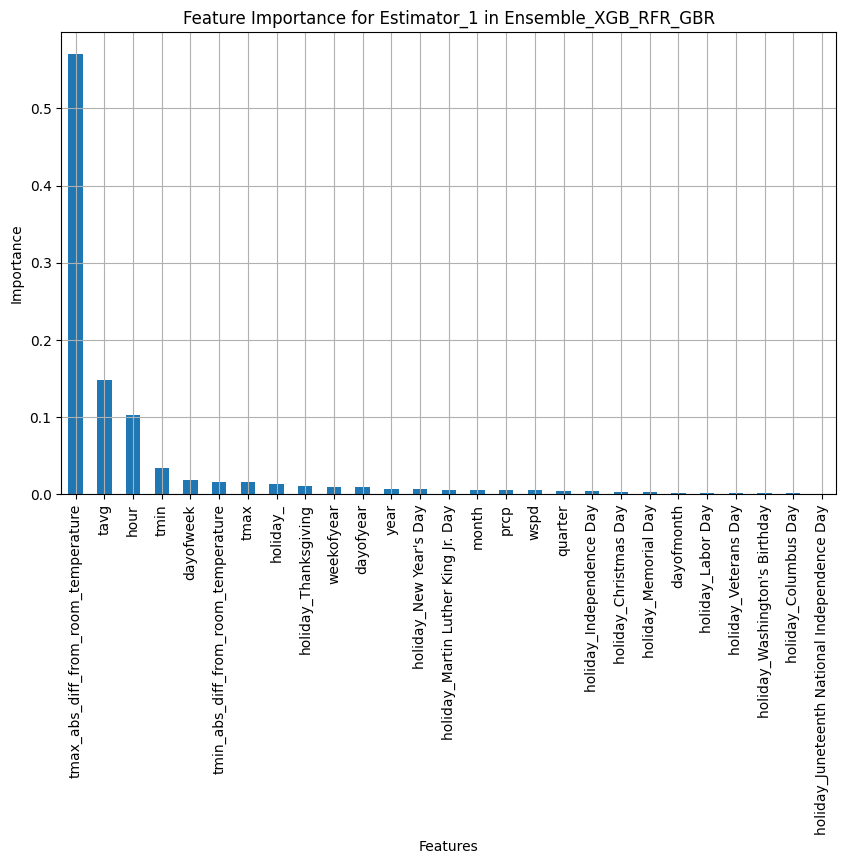

Feature Importance for Estimator_2 in Ensemble_XGB_RFR_GBR:
hour                                            0.362261
tmax_abs_diff_from_room_temperature             0.336131
tavg                                            0.180834
dayofweek                                       0.023092
tmin_abs_diff_from_room_temperature             0.020184
tmin                                            0.019367
dayofyear                                       0.013085
tmax                                            0.011315
wspd                                            0.008870
year                                            0.007444
weekofyear                                      0.005584
prcp                                            0.004519
dayofmonth                                      0.004446
month                                           0.001182
holiday_                                        0.000793
quarter                                         0.000335
holiday_Thanksgiving        

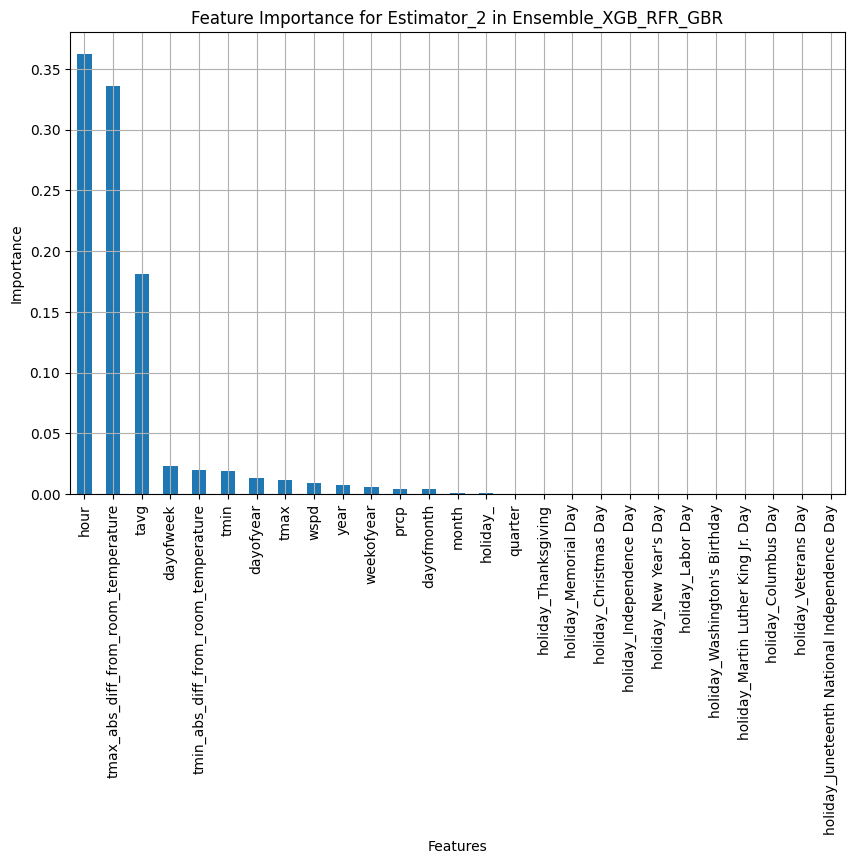

Feature Importance for Estimator_3 in Ensemble_XGB_RFR_GBR:
hour                                            0.372443
tmax_abs_diff_from_room_temperature             0.334295
tavg                                            0.181968
tmin                                            0.029452
dayofweek                                       0.021895
dayofyear                                       0.015764
tmin_abs_diff_from_room_temperature             0.010095
tmax                                            0.008801
year                                            0.007765
wspd                                            0.006671
prcp                                            0.003787
weekofyear                                      0.003622
dayofmonth                                      0.001595
holiday_                                        0.001105
month                                           0.000257
quarter                                         0.000209
holiday_Thanksgiving        

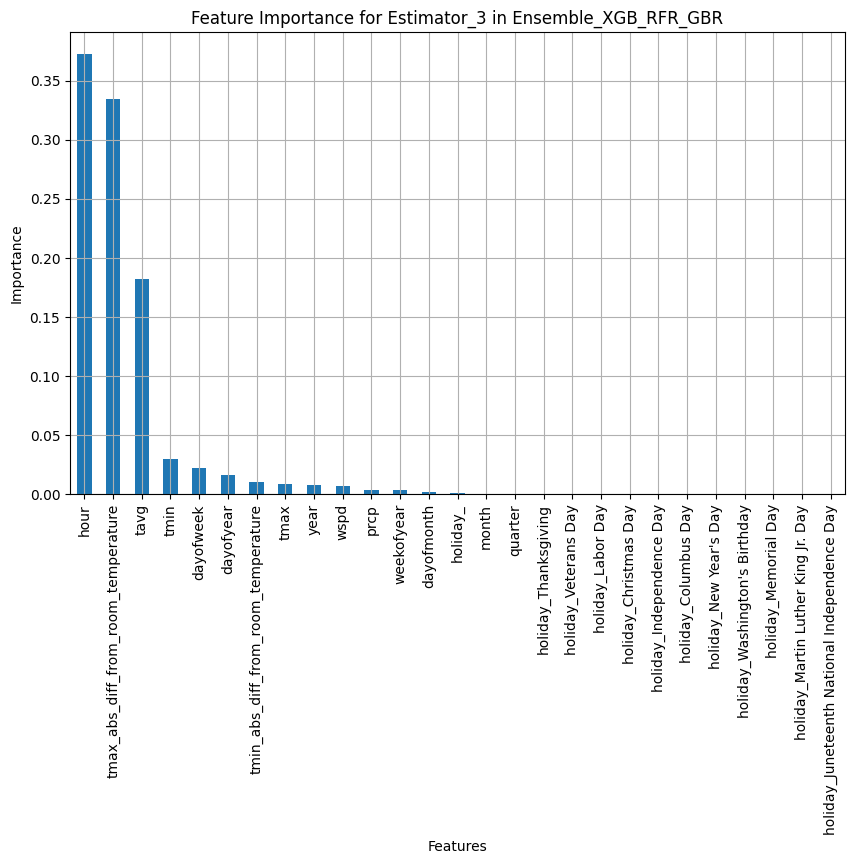

In [31]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from joblib import load
import matplotlib.pyplot as plt
import seaborn as sns

# Load the ensemble models
ensemble_1 = load('saved models/Ensemble learning/ensemble_voting_model_xgb_gbr.joblib')
ensemble_2 = load('saved models/Ensemble learning/ensemble_voting_model.joblib')

# List of ensemble models for iteration
ensemble_models = [
    ('Ensemble_XGB_GBR', ensemble_1),
    ('Ensemble_XGB_RFR_GBR', ensemble_2)
]

# Ensure y_test is numeric and handle invalid values
y_test_numeric = pd.to_numeric(y_test, errors='coerce')  # Convert to numeric, set invalid values to NaN
y_test_numeric = y_test_numeric.dropna()  # Drop any NaN values

# Initialize an empty list to store evaluations
ensemble_evaluations = []

# Create a DataFrame to store the actuals and predictions
results_df = test[['datetime', 'energy_consumption_mw']].copy()
results_df.columns = ['datetime', 'Actual']  # Rename for clarity

# Evaluate each ensemble model
for model_name, model in ensemble_models:
    predictions = model.predict(X_test_scaled)
    results_df[model_name + ' Predictions'] = predictions
    
    mae = mean_absolute_error(y_test_numeric, predictions)
    mape = mean_absolute_percentage_error(y_test_numeric, predictions) * 100
    rmse = mean_squared_error(y_test_numeric, predictions, squared=False)
    r2 = r2_score(y_test_numeric, predictions)
    
    ensemble_evaluations.append([model_name, mape, mae, rmse, r2])

# Convert ensemble evaluations to a DataFrame and export as CSV
ensemble_evaluations_df = pd.DataFrame(ensemble_evaluations, columns=['Model Name', 'MAPE', 'MAE', 'RMSE', 'R2'])
ensemble_evaluations_df.to_csv('results/ensemble_model_evaluations.csv', index=False)

# Export the combined actual vs. predictions CSV for all ensemble models
results_df.set_index('datetime', inplace=True)
results_df.to_csv('results/actuals_vs_predictions_combined_ensemble.csv')

# Plot scatter plot of True vs Predicted values for each ensemble model
for model_name, model in ensemble_models:
    predictions = model.predict(X_test_scaled)
    
    # Convert predictions to numeric and remove any non-finite values
    predictions_numeric = pd.to_numeric(predictions, errors='coerce')
    predictions_numeric = predictions_numeric[np.isfinite(predictions_numeric)]
    
    # Ensure both arrays are the same length
    min_len = min(len(y_test_numeric), len(predictions_numeric))
    y_test_numeric_trimmed = y_test_numeric.iloc[:min_len]  # Trim y_test to min length
    predictions_numeric_trimmed = predictions_numeric[:min_len]  # Trim predictions to min length
    
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_test_numeric_trimmed, y=predictions_numeric_trimmed, alpha=0.6)
    
    # Plot a perfect prediction line (y = x)
    plt.plot([y_test_numeric_trimmed.min(), y_test_numeric_trimmed.max()],
             [y_test_numeric_trimmed.min(), y_test_numeric_trimmed.max()],
             color='red', lw=2, linestyle='--')
    
    plt.xlabel('Actual Energy Consumption')
    plt.ylabel(f'Predicted Energy Consumption ({model_name})')
    plt.title(f'Scatterplot of Actual vs Predicted for {model_name}')
    plt.grid(True)
    plt.show()

# Line plot of predictions vs actuals for each model separately
for model_name, model in ensemble_models:
    predictions = model.predict(X_test_scaled)
    predictions_numeric = pd.to_numeric(predictions, errors='coerce')
    predictions_numeric = predictions_numeric[np.isfinite(predictions_numeric)]
    
    # Ensure both arrays are the same length
    min_len = min(len(test['datetime']), len(predictions_numeric))
    
    plt.figure(figsize=(12, 6))
    plt.plot(test['datetime'][:min_len], y_test_numeric.iloc[:min_len], label='Actual')
    plt.plot(test['datetime'][:min_len], predictions_numeric[:min_len], label=f'{model_name} Predictions')
    
    plt.xlabel('Datetime')
    plt.ylabel('Energy Consumption (MW)')
    plt.title(f'Actual vs Predictions for {model_name}')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.show()

# Feature importance - since the VotingRegressor is an ensemble of different models, extracting feature importance requires accessing individual models
for model_name, model in ensemble_models:
    print(f'Feature Importance for {model_name} is model dependent, retrieving individual model importances...')

    # Iterate through the individual models in the ensemble
    for i, estimator in enumerate(model.estimators_):
        estimator_name = f'Estimator_{i + 1}'
        if hasattr(estimator, 'feature_importances_'):
            feature_importance = pd.Series(estimator.feature_importances_, index=X_test.columns).sort_values(ascending=False)
            print(f'Feature Importance for {estimator_name} in {model_name}:')
            print(feature_importance)

            # Plot the feature importance
            plt.figure(figsize=(10, 6))
            feature_importance.plot(kind='bar')
            plt.title(f'Feature Importance for {estimator_name} in {model_name}')
            plt.xlabel('Features')
            plt.ylabel('Importance')
            plt.grid(True)
            plt.show()
        else:
            print(f"{estimator_name} in {model_name} does not have a feature importance attribute.")



# SVR

SVR model does not provide feature importance. Skipping this step.


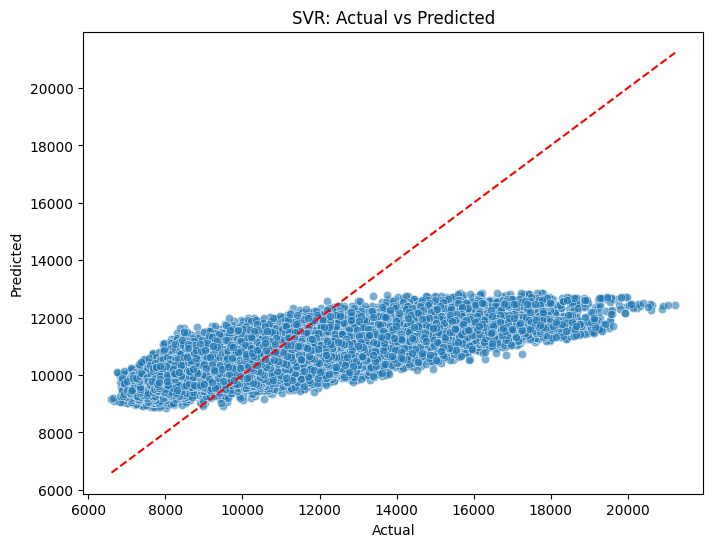

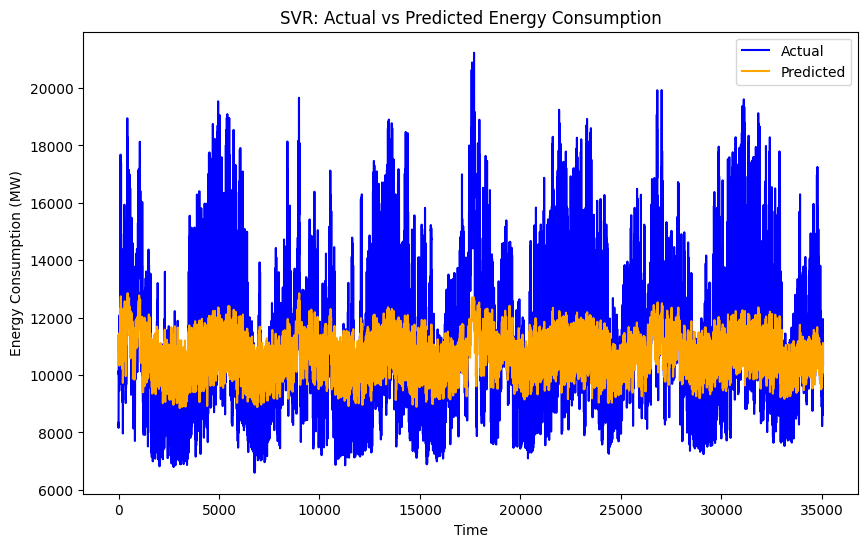

SVR model evaluation and results saved successfully.


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from joblib import load
import seaborn as sns

# Load the pre-trained SVR model
svr_model = load('saved models/SVR/svr_all2019_reg_model.joblib')

# Step 1: Make Predictions using the SVR model
predictions = svr_model.predict(X_test_scaled)

# Inverse scaling if necessary (if the target variable was scaled)
# In this case, it's already in original form so we skip inverse transform for predictions
# Assuming y_test was not scaled, so we keep using original

# Step 2: Model Evaluation
rmse = mean_squared_error(y_test, predictions, squared=False)
mae = mean_absolute_error(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

# Collect evaluation metrics in a DataFrame
evaluation_results = pd.DataFrame({
    'model_name': ['SVR'],
    'MAPE': [mape * 100],
    'MAE': [mae],
    'RMSE': [rmse],
    'R2': [r2]
})

# Export evaluation results to CSV
evaluation_results.to_csv('results/svr_evaluation_results.csv', index=False)

# Step 3: Plot Feature Importance (not applicable for SVR as it doesn't have feature importance)
print("SVR model does not provide feature importance. Skipping this step.")

# Step 4: Scatter plot of True vs Predicted with regression line
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=predictions, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Perfect prediction line
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('SVR: Actual vs Predicted')
plt.savefig('results/svr_actual_vs_predicted_scatter.png')
plt.show()

# Step 5: Line plot of Predictions vs Actuals
plt.figure(figsize=(10, 6))
plt.plot(y_test.reset_index(drop=True), label='Actual', color='blue')
plt.plot(predictions, label='Predicted', color='orange')
plt.title('SVR: Actual vs Predicted Energy Consumption')
plt.xlabel('Time')
plt.ylabel('Energy Consumption (MW)')
plt.legend()
plt.savefig('results/svr_actual_vs_predicted_line.png')
plt.show()

# Step 6: Export actuals and predictions to CSV with datetime as the index
test['Predicted'] = predictions
result_df = test[['datetime', 'energy_consumption_mw', 'Predicted']].set_index('datetime')
result_df.columns = ['Actual', 'SVR_Predicted']
result_df.to_csv('results/svr_predictions_vs_actuals.csv')

print("SVR model evaluation and results saved successfully.")

# SHAP ANALYSIS

In [39]:
pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 257.6 kB/s eta 0:00:0000:0100:02
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 438.8 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 636.6 kB/s eta 0:00:0000:0100:01
  Using cached pandas-2.1.4-cp39-cp39-macosx_10_9_x86_64.whl (11.8 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 727.3 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 450.3 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 753.4 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 319.0 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 508.1 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 477.5 kB/s eta 0:00:0000:0100:03
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.9/38.9 MB 515.7 kB/s eta 0:00:0000:0100:02
     ━━━━━━━━━━━━━━

In [ ]:
import shap
from joblib import load
from sklearn.preprocessing import MinMaxScaler

# Load models
best_xgb = load('saved models/XGB/xgb_best_model_grid_search2.joblib')
best_rfr = load('saved models/RFR/rfr_best_model_grid_search2.joblib')
best_gbr = load('saved models/GBR/gbr_best_model_grid_search2.joblib')

In [ ]:
explainer_xgb = shap.TreeExplainer(best_xgb)
shap_values_xgb = explainer_xgb.shap_values(X_test_scaled)

In [ ]:
explainer_rfr = shap.TreeExplainer(best_rfr)
shap_values_rfr = explainer_rfr.shap_values(X_test_scaled)

In [ ]:
explainer_gbr = shap.TreeExplainer(best_gbr)
shap_values_gbr = explainer_gbr.shap_values(X_test_scaled)

In [ ]:
# For XGBoost
shap.summary_plot(shap_values_xgb, X_test_scaled, feature_names=X_test.columns)

# For Random Forest
shap.summary_plot(shap_values_rfr, X_test_scaled, feature_names=X_test.columns)

# For Gradient Boosting
shap.summary_plot(shap_values_gbr, X_test_scaled, feature_names=X_test.columns)

In [ ]:
# For XGBoost
shap.dependence_plot('feature_name', shap_values_xgb, X_test_scaled, feature_names=X_test.columns)

In [ ]:
# For a single prediction
shap.force_plot(explainer_xgb.expected_value, shap_values_xgb[0,:], X_test_scaled[0,:], feature_names=X_test.columns)
